# Correlating NGSS and State Based Science Standards   
Capstone Project - The Flatiron School - By Kristen Davis

In April of 2013 a collection of rigorous and internationally benchmarked standards for K-12 science education standards were released, called [Next Generation Science Standards (NGSS)](https://www.nextgenscience.org/). These standards were crafted to prepare students to be better decision makers about scientific and technical issues and to apply science to their daily lives. By blending core science knowledge with scientific practices, students are engaged in a more relevant context that deepens their understanding and helps them build what they need to move forward with their education. However, these standards were of voluntary adoption at the time and many states chose not to change their current (common core) standards. 

Currently, 18 states have fully adopted the NGSS for their K -12 science curriculum, 26 are self reported as 'aligned' to the NGSS standards and eight have independently developed standards. Much qualitative work is done to measure alignment. Each of these states deployed teams of industry experts to spend months to achieve this alignment. Yet little quantitative work has been applied to understand alignment. With the surge in tools provided in the Natural Language Processing package, the idea that an organization could quantify its alignment is within reach. By identifying word frequencies and text patterns in the NGSS standards and comparing them to state standards, this project aims to do just that, providing not only insight into the similarities and differences of science education across America, but also develop a tool that could be used more broadly to quantify alignment cross industry. 

# Libraries & Data Packages 
A broad array of libraries and functions that are implemented through the notebook including custom built functions.

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#custom functions 
from projectfunctions import * 

In [52]:
#Data Collections
from bs4 import BeautifulSoup 
import requests  
from time import sleep  
import numpy as np 
from random import randint

#Data Analysis 
import pandas as pd
import numpy as np  
np.random.seed(0) 
import pickle

#Data Visulaization 
import matplotlib.pyplot as plt   
import plotly.express as px 
import plotly.graph_objects as go 
import plotly.figure_factory as ff 
from urllib.request import urlopen
import json  
import seaborn as sns  
from PIL import Image


#Natural Language Processing 
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words("english")
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist 
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.collocations import * 
import string 
import re 
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
import gensim 
from gensim.parsing.preprocessing import preprocess_documents 
import py_stringmatching as sm 
from gensim.models import Word2Vec 
from fuzzywuzzy import fuzz 
from py_stringmatching import MongeElkan, Levenshtein, BagDistance, Jaccard

#Modeling 
from sklearn.cluster import MiniBatchKMeans, KMeans 
from sklearn.decomposition import PCA  

from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.metrics import calinski_harabasz_score, confusion_matrix 
from sklearn.metrics import classification_report 

from sklearn.datasets import fetch_20newsgroups 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.naive_bayes import MultinomialNB  
from scipy.spatial.distance import pdist, squareform 
from sklearn.manifold import TSNE 
from collections import defaultdict 
from sklearn.pipeline import make_pipeline 
from sklearn.svm import LinearSVC 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score 
from scipy.cluster.hierarchy import ward, dendrogram 
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.manifold import MDS

# NGSS Standards  
A set of K - 12 Science standards centered around three dimensions: core ideas, practices, and cross cutting concepts. This will be the primary text used in this project and the benchmark used in analysis and comparison.

## Text Processing 
A general text cleaning as well as specific text based word removal.

The first step is reading in and cleaning the NGSS standards. This pdf document includes not only the specific science standard but also a general introduction into each grade, giving a context for the meaning and weight the creators put on certain ideas, concepts and words. General processing can be compiled into a function to open the file, tokenize the document and then remove general English language stop words and numbers that may be included in the text.

In [39]:
ngss = open_and_flatten('ProcessedStandardsDataTXT/ngs')

In [9]:
len(ngss)

41743

Now that I have a generally cleaned corpus I want to apply text specific cleaning. Examples of this would include words to indicate level, such as 'high school' or 'kindergarten' etc. 

In [10]:
#look at the top 50 words on general process ngss  
ngss_generalclean_freqdist = FreqDist(ngss)
ngss_generalclean_freqdist.most_common(10)

[('evidence', 467),
 ('core', 438),
 ('ideas', 415),
 ('energy', 389),
 ('include', 305),
 ('using', 304),
 ('information', 302),
 ('engineering', 299),
 ('use', 296),
 ('data', 292)]

Using the above as a reference, I can remove frequently occurring words that will not add value or skew results. These words include administrative words (eg. reserved, high frequency classifying words (eg. hs). This processes is by no means extensive and future work could include additional cleaning (of low frequency words) and exploration of how word removal/ inclusion affects comparison and analysis. 


In [12]:
#remove additional stop words
ngss_stopwords_list = ['hs', 'ms', 'ls', 'ess', 'ps', 'state', 'standards', 
                       'permisssion', 'inc', 'september', 'rights reserved', 
                       'ets', 'science', 'rights', 'reserved', 'section', 
                       'entitled', 'marked', 'asterisk', 'science', 'archive', 
                      'preformance', 'expectations', 'assessment', 'boundary',
                       'sciences',  'achieve', 'reproduced', 'verbatium',
                       'reprinted', 'permission', 'ideas verbatium', 'mp',
                       'could', 'grade', 'framework', 'one', 'dcis']
ngss_processed = [word for word in ngss if word not in ngss_stopwords_list] 

#re examine frequency list
ngss_freqdist = FreqDist(ngss_processed)
ngss_top10 = ngss_freqdist.most_common(10)  
print("Top 10 Highest Frequency Words")
ngss_top10

Top 10 Highest Frequency Words


[('evidence', 467),
 ('core', 438),
 ('ideas', 415),
 ('energy', 389),
 ('include', 305),
 ('using', 304),
 ('information', 302),
 ('engineering', 299),
 ('use', 296),
 ('data', 292)]

The most frequently occurring words are: Evidence, Core, Ideas, Energy, Include. These words clearly represent what the NGSS believe is important to high quality science education. Thus we should see these words (or synonyms) appear with high frequency in state standards that are aligned with the NGSS standards.

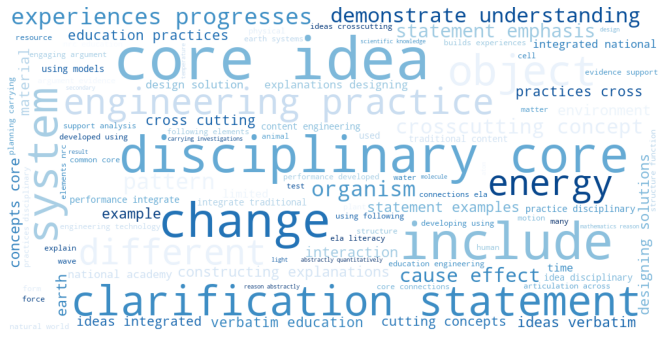

In [13]:
#ngss word cloud 
word_cloud(ngss_processed)

## Word Relationships 
Examine the word relationships within the NGSS corpus. 

In addition to frequency patterns, I think it is important to understand words patterns, which will yield context to the words within the document. By examining bigrams and point matrix indexes and Gensim word embedding, more insight can be gained into how the NGSS standards talk about the process and importances while learning science. 

In [152]:
#ngss bigram pairs 
print("Bigram Pairs:")
bigram_generator(ngss_processed, 5)

Bigram Pairs:


[(('core', 'ideas'), 0.007272727272727273),
 (('disciplinary', 'core'), 0.00654040404040404),
 (('clarification', 'statement'), 0.0044444444444444444),
 (('experiences', 'progresses'), 0.0028787878787878787),
 (('demonstrate', 'understanding'), 0.0025505050505050504)]

In [153]:
#ngss pmi pairs  
print("PMI Pairs:")
pmi_generator(ngss_processed, 100)

PMI Pairs:


[(('clarification', 'statement'), 7.789397032590077),
 (('experiences', 'progresses'), 7.347983733650299),
 (('demonstrate', 'understanding'), 7.269145346003947),
 (('disciplinary', 'core'), 6.481811036402263),
 (('core', 'ideas'), 5.971383225461185)]

Disciplinary core ideas, this is one the strands NGSS has built itself on and is referenced in context at a very high frequency. After that clarification statement, while this is an administrative word I left it in because I believe it demonstrates the intent within the NGSS to be understandable, to be readable thus we see clarification statements through out the document as a it attempts to explain itself. The final two pairings speak to student experience, a progression of experience and an demonstration of understanding. The fundamentals of learning.

In [14]:
#word ebeddings 
model = gensim.models.Word2Vec([ngss_processed], min_count=100, window=5, 
                               size=150)

Examine the most positively & negatively (similar/ dissimilar) associated words within the corpus. Sentiment analysis will further deepen our understanding of the document. 

- evidence
('based', 0.9997807145118713)
('scientific', 0.9997705817222595)
('data', 0.9997388124465942)
('multiple', 0.9997205138206482)
('natural', 0.999719500541687)
('use', 0.9997112154960632)
('world', 0.9996839761734009)
('model', 0.9996721148490906)
('describe', 0.9996556043624878)
('experiences', 0.9996338486671448)


- core
('disciplinary', 0.999762773513794)
('ideas', 0.9997358322143555)
('idea', 0.9997168779373169)
('practices', 0.9996705055236816)
('education', 0.9996606111526489)
('performance', 0.9996301531791687)
('concepts', 0.9995719790458679)
('integrate', 0.999523401260376)
('problems', 0.9993098974227905)
('mathematics', 0.9992674589157104)


- ideas
('disciplinary', 0.9997749328613281)
('education', 0.9997414350509644)
('core', 0.9997358322143555)
('idea', 0.9997312426567078)
('performance', 0.9997259974479675)
('concepts', 0.9997085928916931)
('practices', 0.9996979236602783)
('engineering', 0.9995068311691284)
('problems', 0.9994727373123169)
('integrate', 0.9994

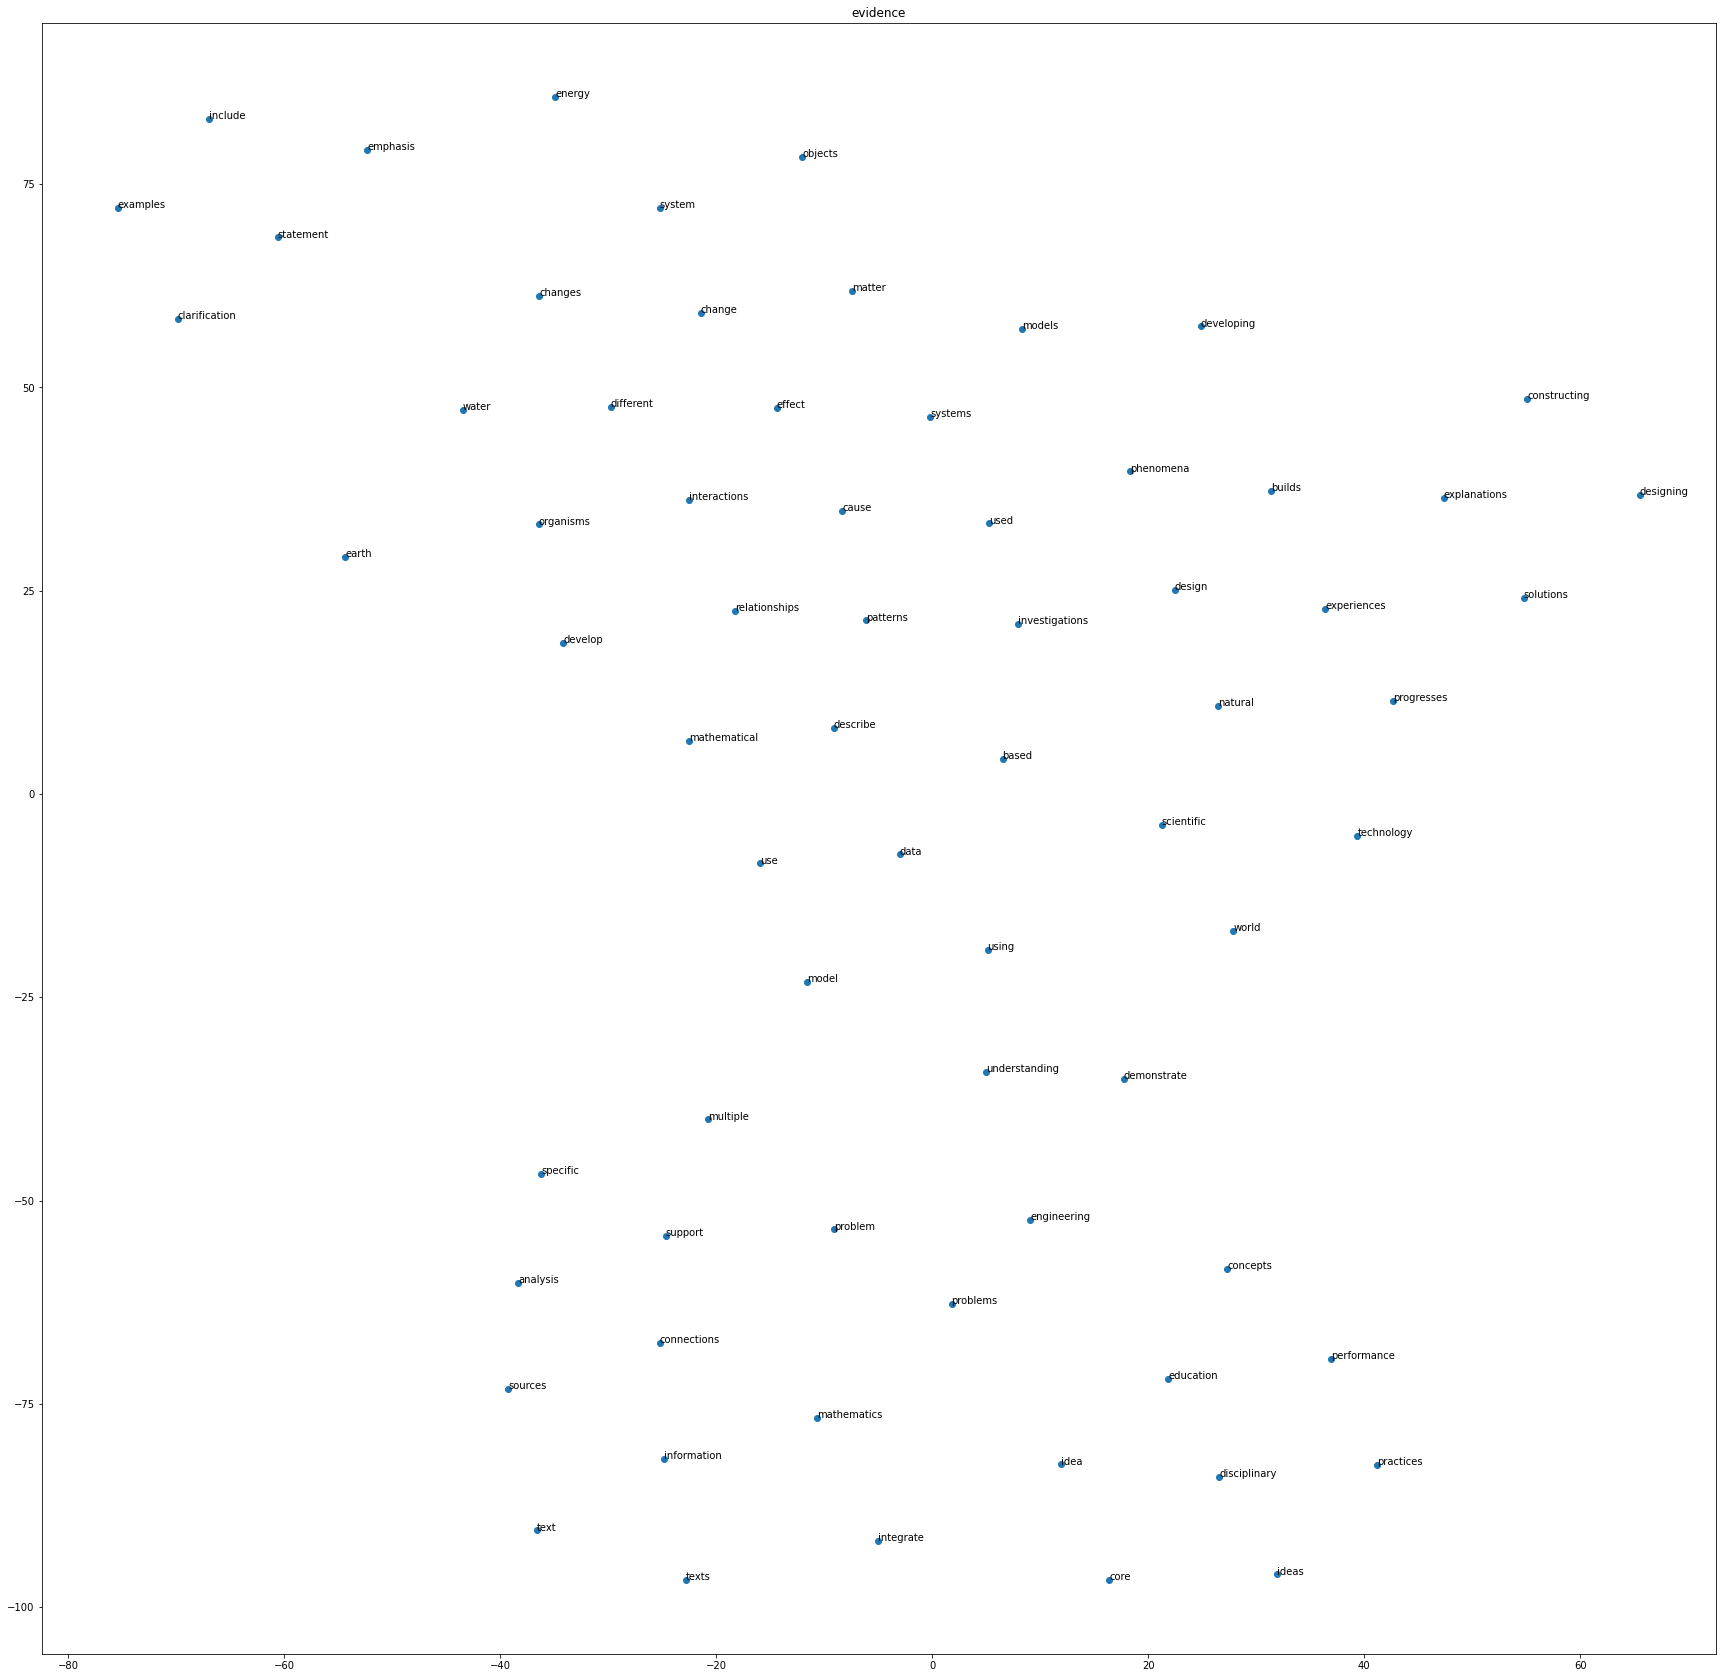

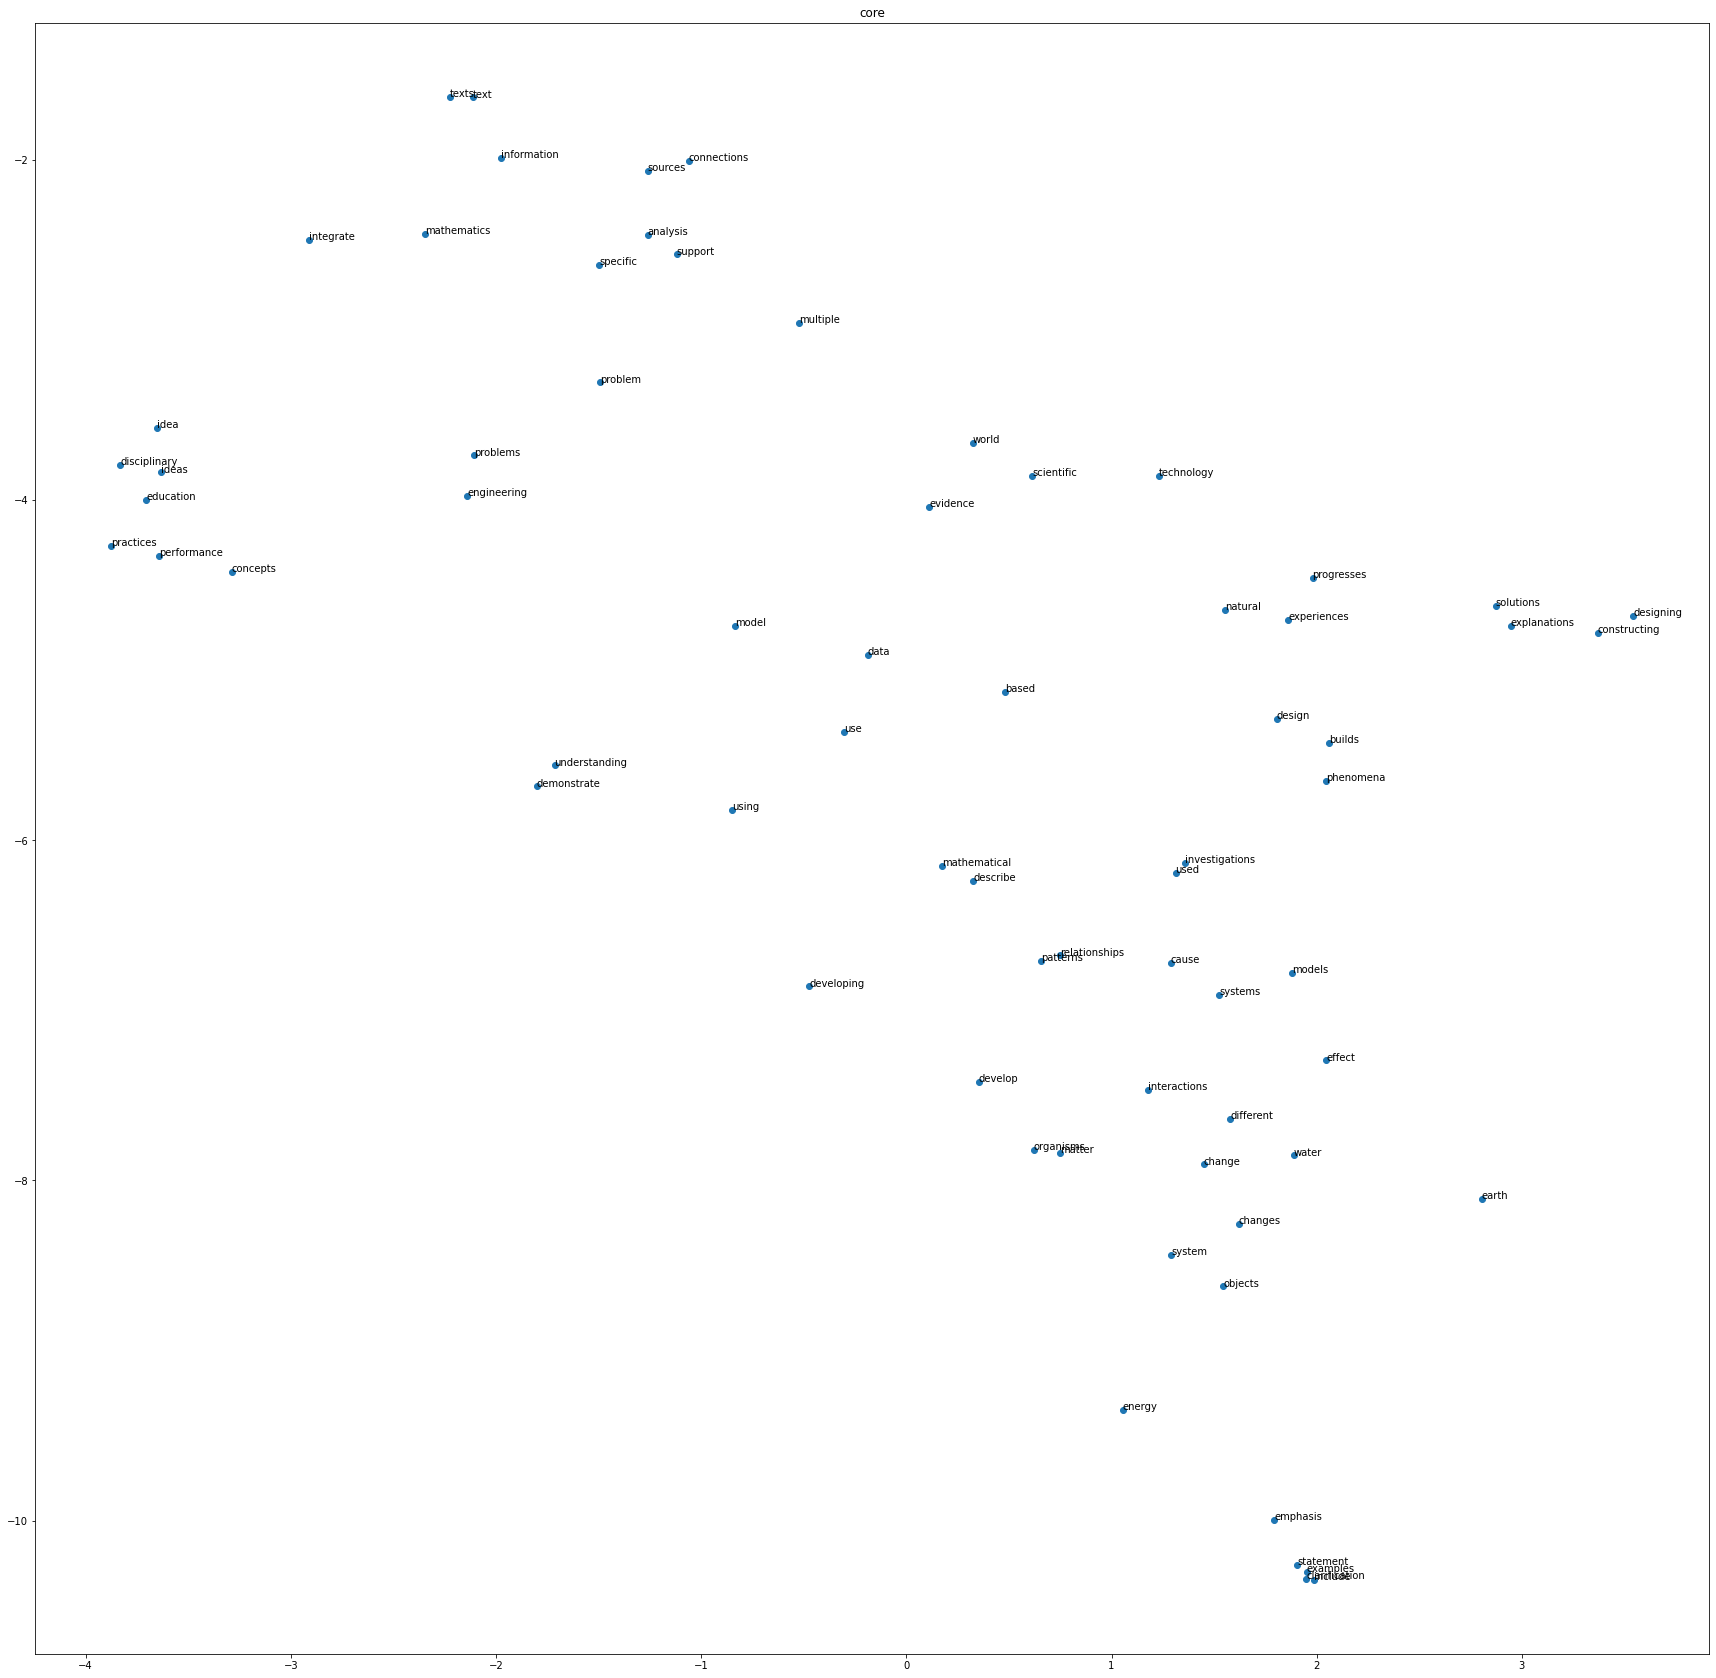

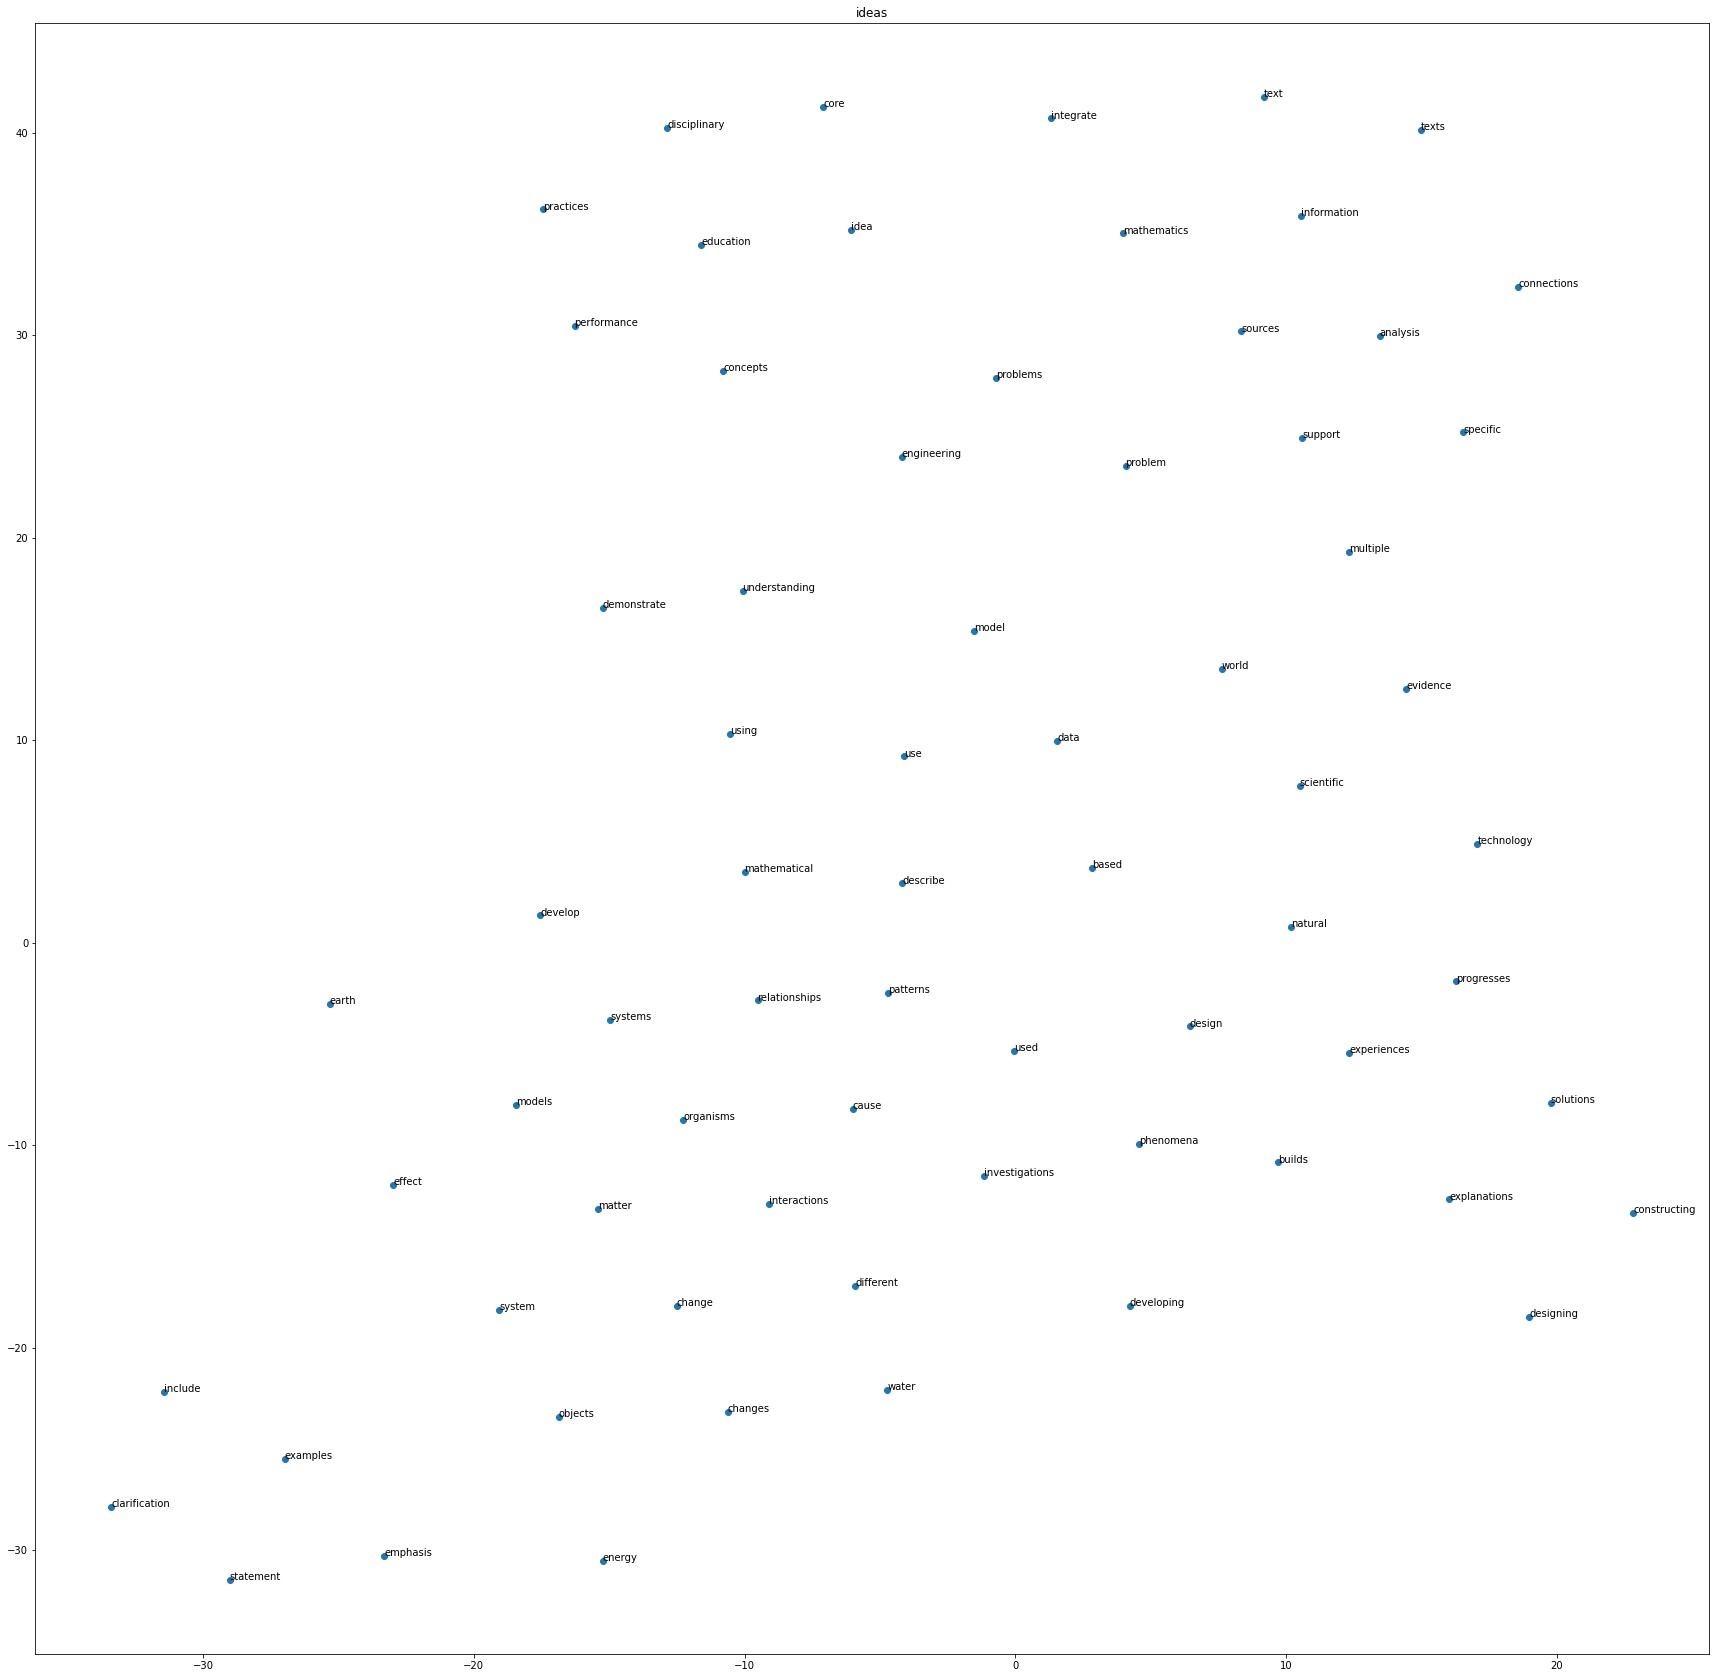

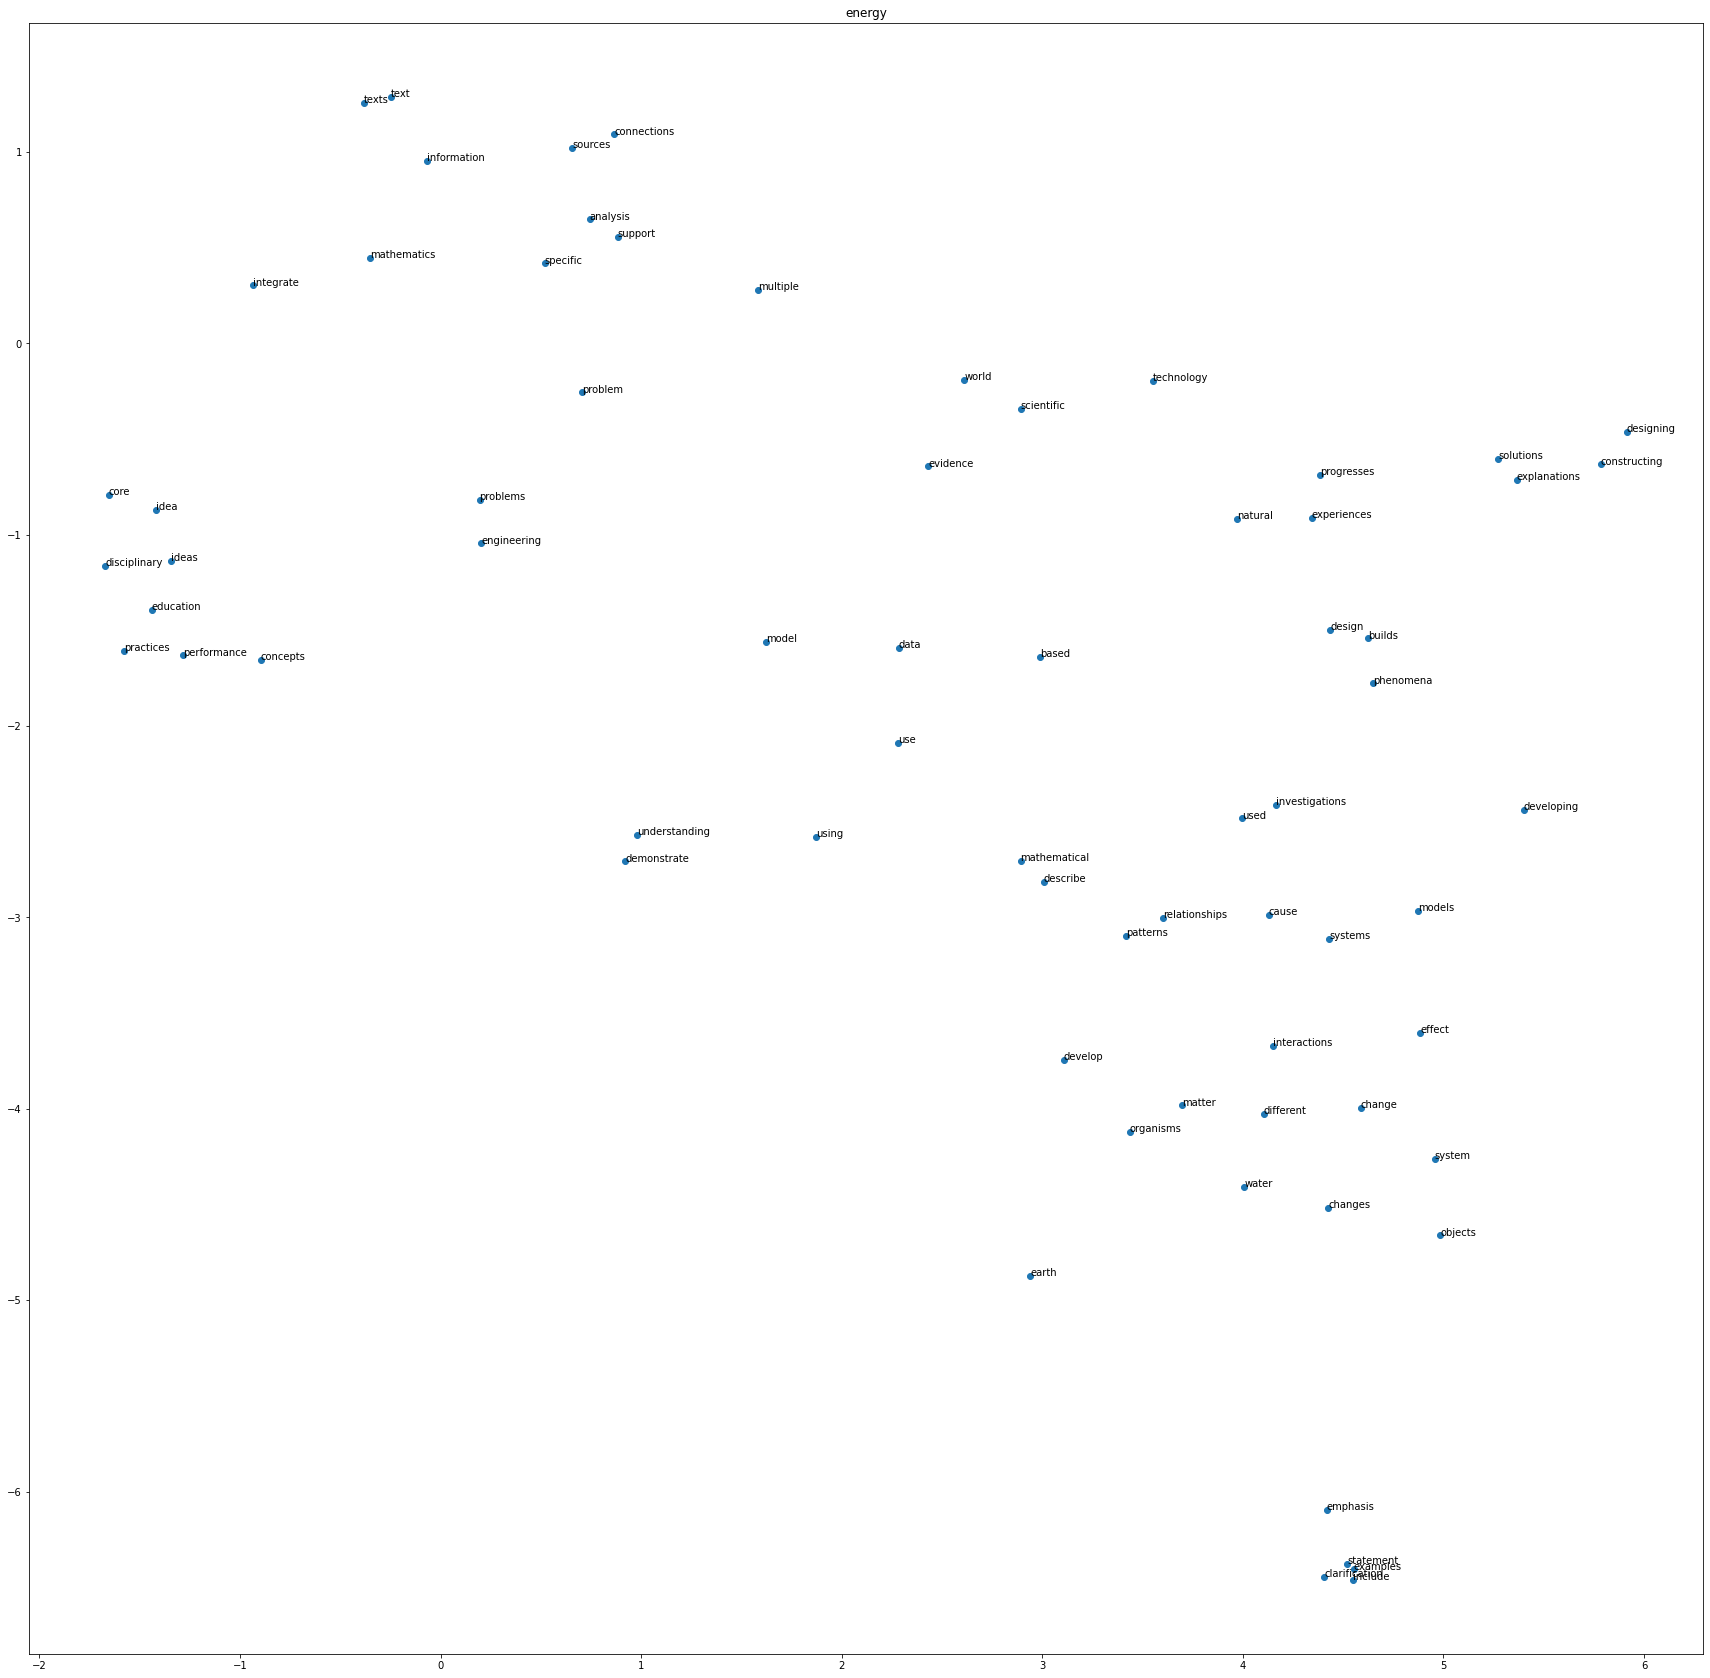

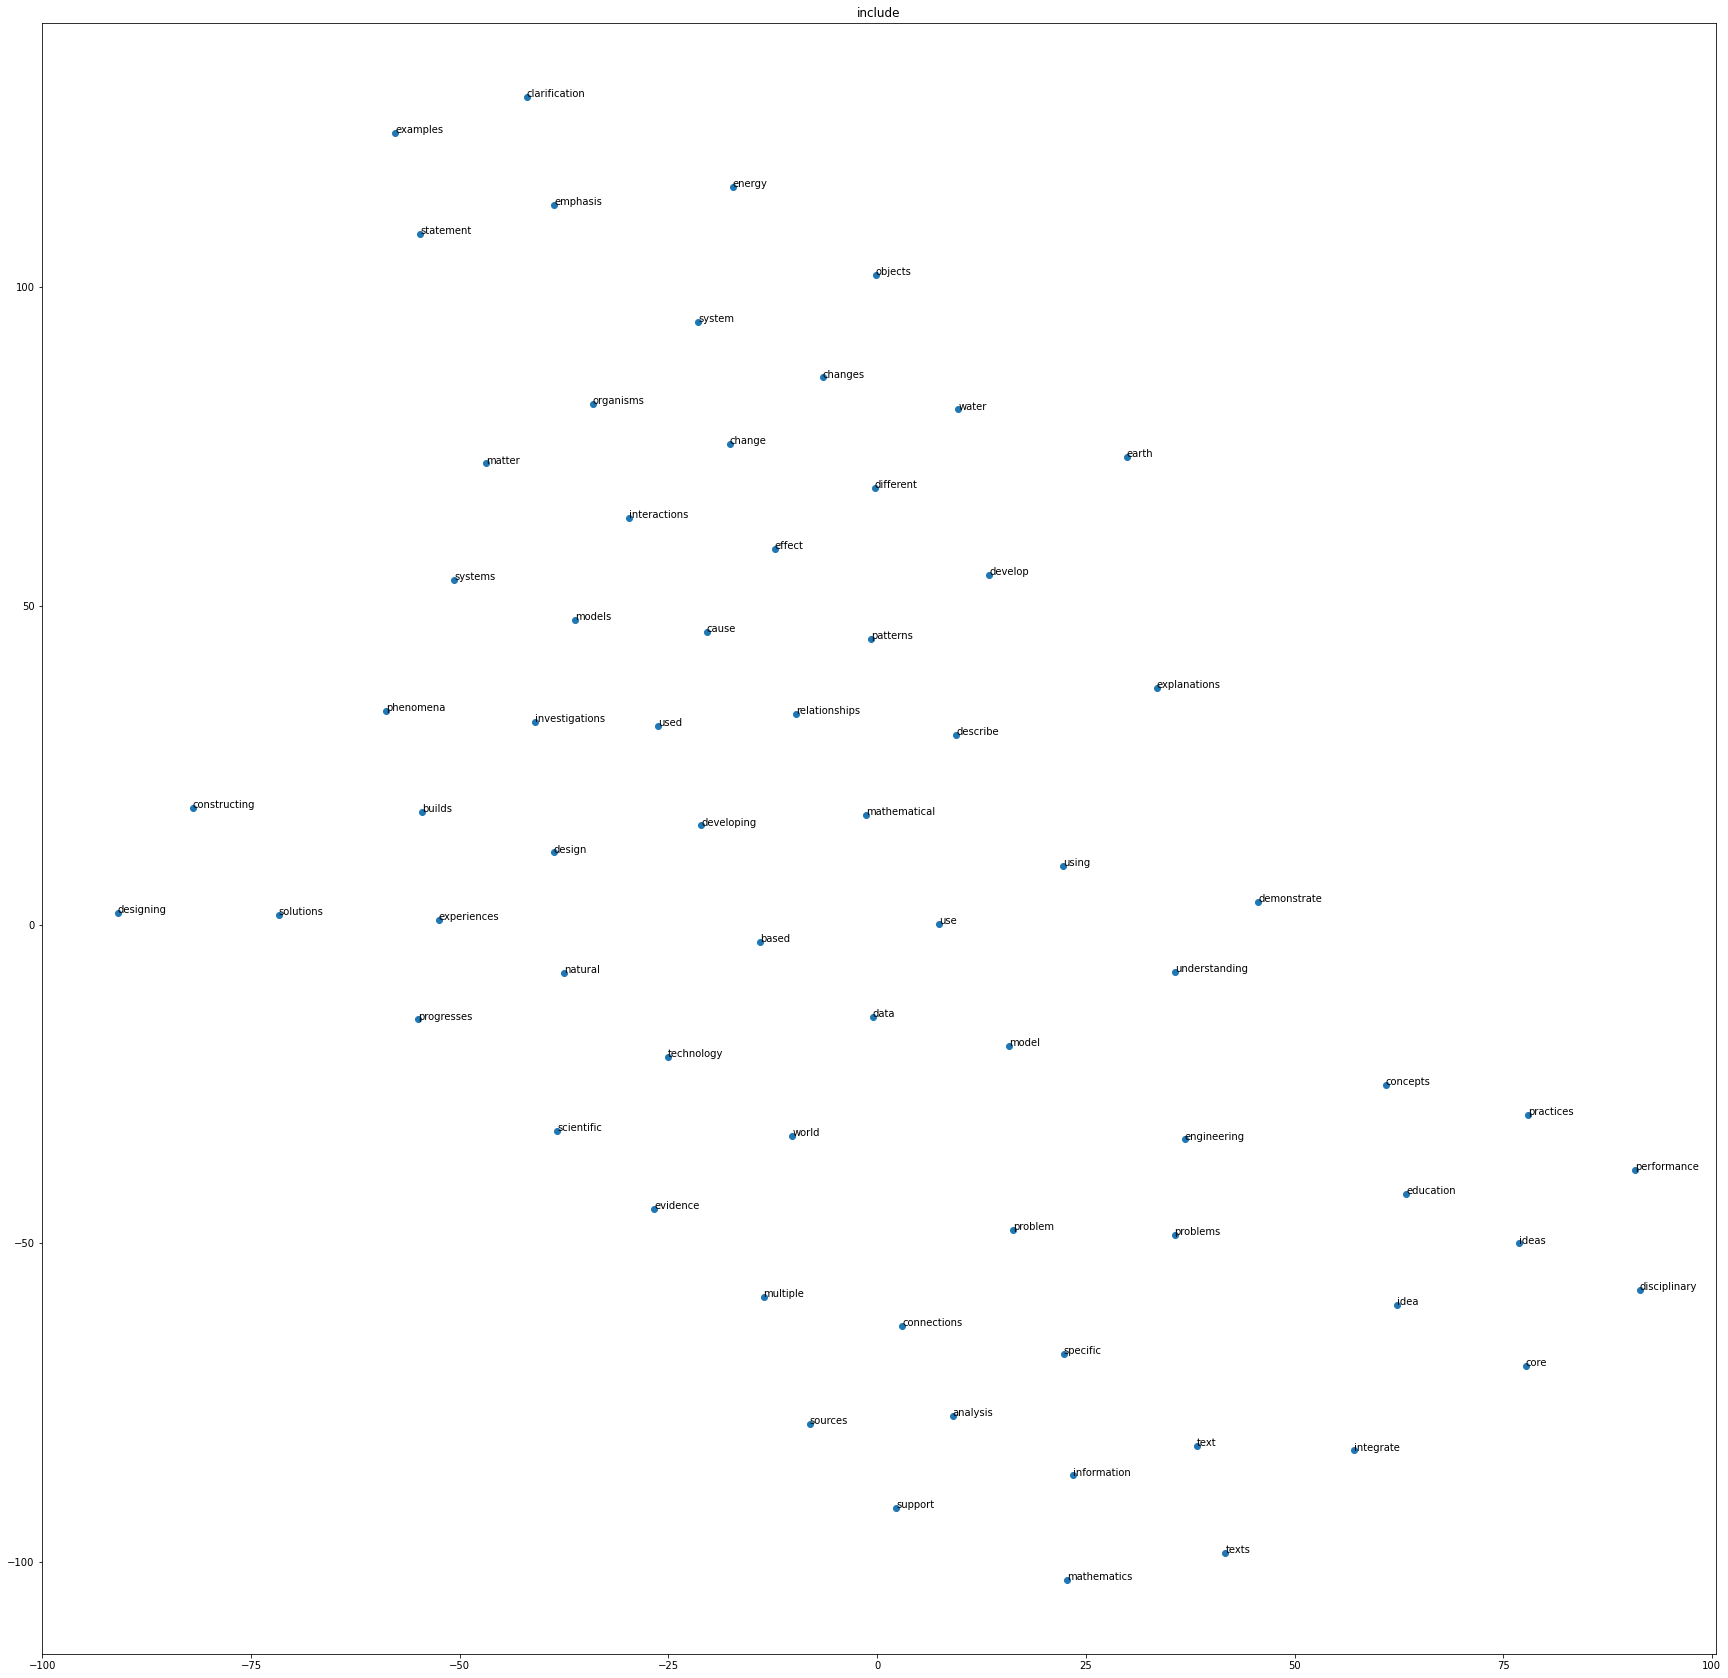

In [15]:
#examine top 10 most similar words 
top_5 = ['evidence', 'core', 'ideas', 'energy','include'] 

for word in top_5: 
    similars = model.wv.similar_by_word(word, topn=10)
    print(f"- {word}", *similars, "\n", sep="\n") 
    
#visualize the density of word relationships
for word in top_5: 
    selected_words = [w[0] for w in model.wv.most_similar(positive=[word], 
                                                          topn=100)]
    embeddings = [model.wv[w] for w in selected_words]

    mapped_embeddings = TSNE(n_components=2, metric='cosine', 
                             init='pca').fit_transform(embeddings) 

    plt.figure(figsize=(30,30)) 
    plt.title(word)
    x = mapped_embeddings[:,0]
    y = mapped_embeddings[:,1]
    plt.scatter(x, y)

    for i, txt in enumerate(selected_words):
        plt.annotate(txt, (x[i], y[i]))

In [16]:
#examine top 10 most dissimilar words 
for word in top_5:  
    dissimilars = model.wv.most_similar(negative=[word])
    #similars = model.wv.similar_by_word(negative = [word], topn=10)
    print(f"- {word}", *dissimilars, "\n", sep="\n") 
    

- evidence
('core', -0.9980870485305786)
('include', -0.9981809258460999)
('disciplinary', -0.9981811046600342)
('practices', -0.9982033371925354)
('examples', -0.9983980655670166)
('clarification', -0.9984056353569031)
('education', -0.9984366297721863)
('idea', -0.9984449744224548)
('ideas', -0.998470664024353)
('statement', -0.9985153675079346)


- core
('include', -0.9956588745117188)
('examples', -0.9958756566047668)
('energy', -0.9959187507629395)
('statement', -0.9959961175918579)
('clarification', -0.9961201548576355)
('designing', -0.9964779615402222)
('emphasis', -0.9965381026268005)
('constructing', -0.9967532753944397)
('system', -0.9970027208328247)
('explanations', -0.9971801042556763)


- ideas
('include', -0.9963623285293579)
('examples', -0.9965397715568542)
('statement', -0.9966922402381897)
('clarification', -0.996735155582428)
('energy', -0.9967416524887085)
('emphasis', -0.9971996545791626)
('designing', -0.9972447156906128)
('constructing', -0.9975181221961975)
('

This follows intuitive and domain knowledge of word associations. The most similar words in to evidence are - based, scientific, multiple, connections, data, analysis, support, world, specific, problem. The scorings on the dissimilar words are a little less intuitive and do not seem to shed any immediate light onto the text.

## EDA Visuals 
Stylized, presentation graphs of high frequency words.

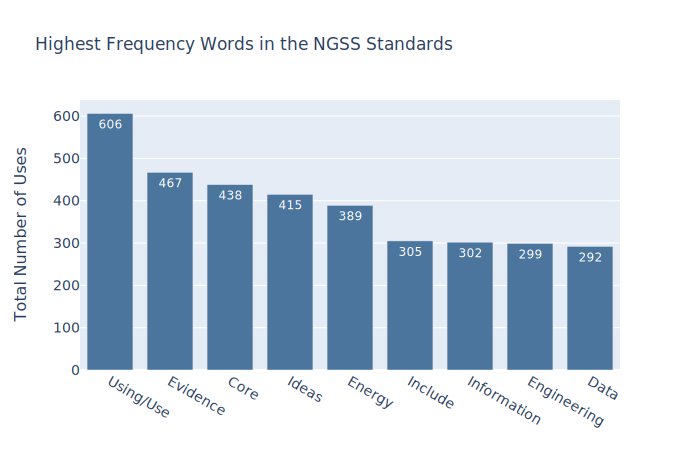

In [21]:
#Graphing of the most frequent ngss words  

x=['Using/Use', 'Evidence', 'Core', 'Ideas', 'Energy', 'Include', 
   'Information', 'Engineering', 'Data']
fig = go.Figure(go.Bar(x=x, y=[606, 467,438,415,389, 305, 302, 299, 292], 
                marker_color='rgb(75, 117, 156)',
                text=[606, 467,438,415,389, 305, 302, 299, 292],
                textposition='auto')) 

fig.update_layout(
    title='Highest Frequency Words in the NGSS Standards',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Total Number of Uses',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1)

fig.show(renderer="svg") 

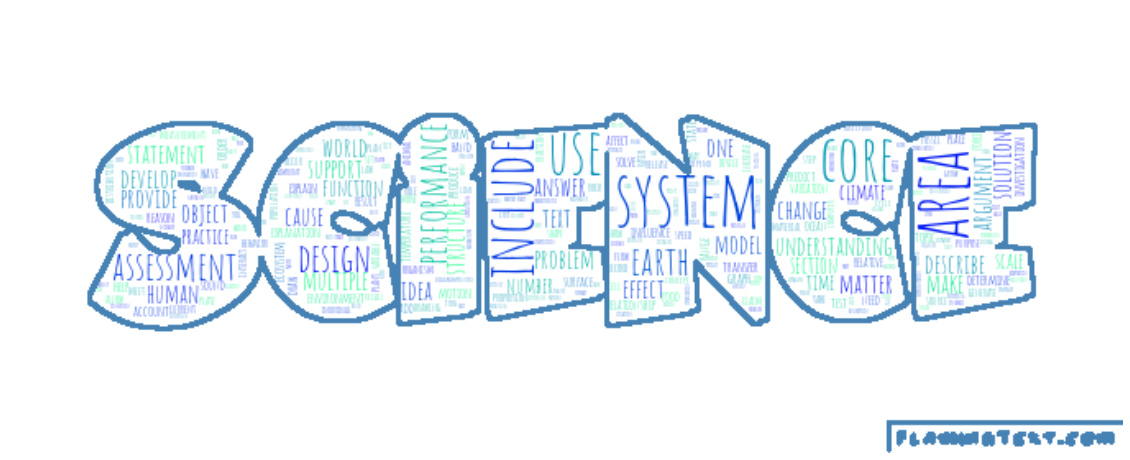

In [81]:
#stylized word cloud 
font_path = '/Users/kristen/Downloads/Amatic_SC/AmaticSC-Regular.ttf' 
custom_mask = np.array(Image.open("/Users/kristen/Downloads/science.png"))
wc_string = (" ").join(ngss_generalclean_freqdist)

wc = WordCloud(stopwords=STOPWORDS, font_path = font_path, 
               mask=custom_mask, contour_width=4, 
               contour_color='steelblue', colormap="winter", 
               background_color="white", max_words=1000,
               max_font_size=300, random_state=42, 
               width= 500, height= 400) 

wc.generate(wc_string) 
plt.figure( figsize=(20,10) )
plt.imshow(wc, interpolation="bilinear")
plt.axis('off') 
plt.show()

## Clustering NGSS Standards  
Use KMeans clustering to group the NGSS standards corpus and identify the word centroids for each cluster.

In [97]:
#ngss processed and tokenized 
len(ngss_processed)

39600

In [112]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_features=200000, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))

tfidf_matrix_ngss = tfidf_vectorizer.fit_transform(ngss_processed) 

print(tfidf_matrix.shape)

(39600, 3234)


In [113]:
#term names
terms = tfidf_vectorizer.get_feature_names() 
dist_ngss = 1 - cosine_similarity(tfidf_matrix_ngss)

Background knowledge would predict that 3-5 clusters will be the best fit. 

In [114]:
k_means_3 = KMeans(n_clusters=3).fit(tfidf_matrix)
k_means_4 = KMeans(n_clusters=4).fit(tfidf_matrix)
k_means_5 = KMeans(n_clusters=5).fit(tfidf_matrix)
k_means_6 = KMeans(n_clusters=6).fit(tfidf_matrix)
k_means_7 = KMeans(n_clusters=7).fit(tfidf_matrix)

k_list = [k_means_3, k_means_4, k_means_5, k_means_6, k_means_7]

In [115]:
CH_score = []

for model in k_list:
    labels = model.labels_
    CH_score.append(calinski_harabasz_score(tfidf_matrix_ngss.toarray(), labels))

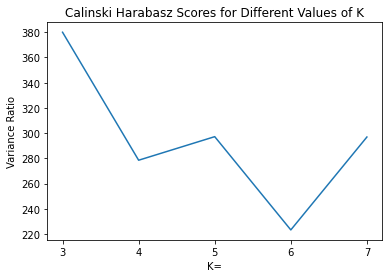

In [102]:
plt.plot([3, 4, 5, 6, 7], CH_score)
plt.xticks([3,4,5,6,7])
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show()

In [103]:
wcss_score = []

for model in k_list:
    labels = model.labels_
    wcss_score.append(model.inertia_)

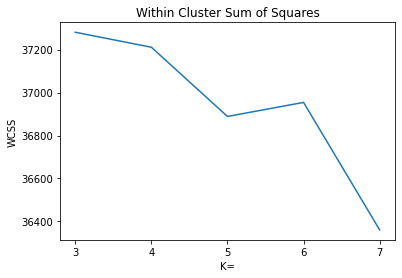

In [104]:
plt.plot([3, 4, 5, 6, 7], wcss_score)
plt.xticks([3,4,5,6,7])
plt.title('Within Cluster Sum of Squares')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.show()

Looks like there is a sharp decline at 4 clusters with the Calinski test and a smaller elbow on the cluster Sum, domain knowledge indicates that 4 is also a good cluster number choice given that the science standards are normally grouped into 3-4 categories depending on the corpus. 

In [105]:
#create and fit a model
km = KMeans(n_clusters=4)

km.fit(tfidf_matrix) 
predicted_clusters = model.predict(tfidf_matrix)

clusters = km.labels_.tolist() 

Look at a list of words in each cluster, which should start to inform theme in our clusters. 

In [119]:
vectorizer = TfidfVectorizer()

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
for i in range(4):
    print ("Cluster %d:" % i),
    for ind in order_centroids[i, :1]:
        print(' %s' % terms[ind]), 
    print

Top terms per cluster:
Cluster 0:
 evidence
Cluster 1:
 core
Cluster 2:
 ideas
Cluster 3:
 data


In [110]:
ngss_cluster_list = pd.DataFrame({'cluster': predicted_clusters, 
                                  'word': clusters})
ngss_cluster_list['cluster'].value_counts() 

0    37953
2      438
1      415
3      302
6      296
5      121
4       75
Name: cluster, dtype: int64

Based on these clusters it seems that three out of the four are about the teaching/ implementing process and only one is a topic (matter - is a physical science key word). This clustering is just on the intra text information, so highlighting a theme within the text, given context themes might include content and/ or explanation on process and instruction. I will apply a similar technique to inter text exploration but intra text clustering could be useful for an organization to better understand what the major themes are.  

## Classify Standards by Topic 
Use supervised learning techniques to predict a standards topic category based on it's description.

In [121]:
#ngs standards, decriptions and dci
standard_df = pickle.load(open("ngsstandards.p", "rb" )) 
standard_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'ngsstandards.p'

In [169]:
#examine unique standards
standard_df['dci'].unique()

array(['Motion and Stability: Forces and Interactions',
       'From Molecules to Organisms: Structures and Processes',
       "Earth's Systems", 'Earth and Human Activity',
       'Waves and Their Applications in Technologies for Information Transf',
       'Heredity: Inheritance and Variation of Traits',
       "Earth's Place in the Univers", 'Matter and Its Interactions',
       'Ecosystems: Interactions, Energy, and Dynamics',
       'Biological Evolution: Unity and Diversity', 'Engineering Design',
       'From molecules to Organisms: Structures and Processes', 'Energy',
       'Matter and its Interactions',
       'Waves and their Applications in Technologies for Information Transf',
       'Ecosystems:  Interactions, Energy, and Dynamics'], dtype=object)

I am going to further generalize the DCI categories by adding another column that classifies the standard as either Physical Science, Earth and Space Science, or Life Science.

In [170]:
#map a generalized label to the specific categories
generalized = {'Motion and Stability: Forces and Interactions': 'PS', 
               'From Molecules to Organisms: Structures and Processes' : 'PS',
               "Earth's Systems" : 'ES',
               'Earth and Human Activity' : 'ES',
               'Waves and Their Applications in Technologies for Information Transf' : 'PS',
               'Heredity: Inheritance and Variation of Traits': 'LS',
               "Earth's Place in the Universe" : 'ES', 
               'Matter and Its Interactions': 'ES',
               'Ecosystems: Interactions, Energy, and Dynamics': 'LS',
               'Biological Evolution: Unity and Diversity': 'LS',
               'Engineering Design': 'PS',
               'From molecules to Organisms: Structures and Processes' : 'LS', 
               'Energy': 'PS',
               'Matter and its Interactions': 'PS',
               'Waves and their Applications in Technologies for Information Transf': 'PS',
               'Ecosystems:  Interactions, Energy, and Dynamics': 'LS'}

standard_df["topic"] = standard_df["dci"].map(generalized)  

#drop nan values
standard_df = standard_df.dropna()

#create a topic id column
standard_df['topic_id'] = standard_df['topic'].factorize()[0]  

category_id_df = standard_df[['topic', 'topic_id']].drop_duplicates() \
                                                    .sort_values('topic_id') 
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['topic', 'topic_id']].values)

standard_df.head()

dci  \
0      Motion and Stability: Forces and Interactions   
1      Motion and Stability: Forces and Interactions   
2  From Molecules to Organisms: Structures and Pr...   
3                                    Earth's Systems   
4                                    Earth's Systems   

                                            standard       tag topic  topic_id  
0  Plan and conduct an investigation to compare t...   K-PS2-1    PS         0  
1  Analyze data to determine if a design solution...   K-PS2-2    PS         0  
2  Use observations to describe patterns of what ...   K-LS1-1    PS         0  
3  Use and share observations of local weather co...  K-ESS2-1    ES         1  
4  Construct an argument supported by evidence fo...  K-ESS2-2    ES         1

In [171]:
standard_df['standard'][3]

'Use and share observations of local weather conditions to describe patterns over time.'

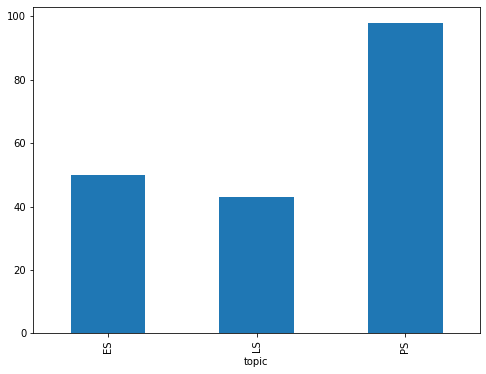

In [172]:
#visualze class distribution 
fig = plt.figure(figsize=(8,6))
standard_df.groupby('topic').topic.count().plot.bar()
plt.show()

In [173]:
#vectorize the text and create features & labels
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(standard_df.standard).toarray()
labels = standard_df.topic
features.shape

(191, 147)

In [174]:
X_train, X_test, y_train, y_test = train_test_split(standard_df['standard'], 
                                                    standard_df['topic'],
                                                    random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

Now that the model has been fit, predict values that are not exact standard strings which classify well with at least one domain key word. (ie. 'energy', 'life', ect.)

In [175]:
print(clf.predict(count_vect.transform(["Use energy"])))

['PS']


Evaluating a variety of models on their preformance scores (accuracy).

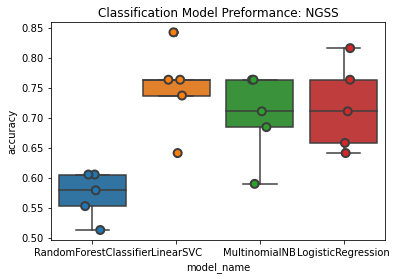

In [176]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] 

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, 
                               scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
                  entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, \
                         columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2) \
              .set_title('Classification Model Preformance: NGSS')
plt.show()

In [177]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.749258
LogisticRegression        0.717679
MultinomialNB             0.702159
RandomForestClassifier    0.570985
Name: accuracy, dtype: float64

The LinearSVC model preformed the best although the LogisticRegrssion Model and MultinomialNB model preformed well also (above 70%).

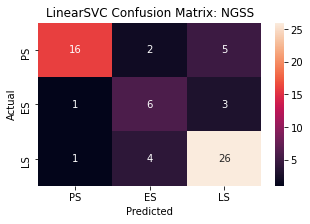

In [178]:
#evaluate the LinearSVC model 
modelsvc= LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = \
                                train_test_split(features, labels, 
                                                 standard_df.index, 
                                                 test_size=0.33, 
                                                 random_state=0)
modelsvc.fit(X_train, y_train)
y_pred = modelsvc.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred) 

fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.topic.values,
            yticklabels=category_id_df.topic.values)
plt.ylabel('Actual')
plt.xlabel('Predicted') 
plt.title('LinearSVC Confusion Matrix: NGSS')
plt.show()

In [179]:
#all words in standards column used in prediction
#with open('classification.pkl', 'wb') as f:
#    pickle.dump(terms, f)  
    
with open('classification.pkl', 'rb') as f:
    terms = pickle.load(f)

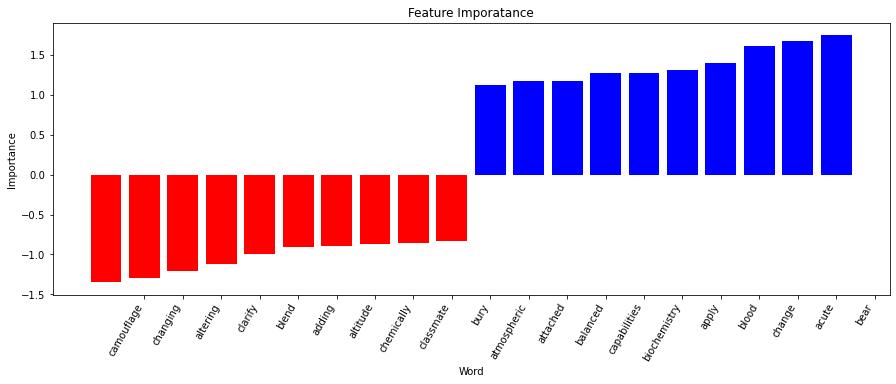

In [180]:
plot_coefficients(modelsvc, terms)

Overall the model preforms strongest in the Life Science topics followed by the Physical Science topics, the lowest preforming category which is Earth Science might be too large a category (it is an amalgamation of ecology and astronomy). Overall it seems that this model is fairly strong. Additional work could be done to add classified standards from the aligned and independent states to increase the training data. The most important words are domain specific words such as 'bear', which makes sense because there would be no such words in the Physical or Earth Science categories.

# State Standards 
The U.S. educational system is decentralized, with each state allowed to create their own standards and metrics for student learning. Thus each state's corpus of standards is unique. All states that have not fully adopted the NGSS standards are represented below. 

## Text Processing 
Each state's standards have been converted to txt file and will be cleaned generically but treated and processed individually. The same functions and process applied to the NGSS standard are applied below. 

In [88]:
us_states = ['ProcessedStandardsDataTXT/alabama',
             'ProcessedStandardsDataTXT/alaska', 
             'ProcessedStandardsDataTXT/arizona', 
             'ProcessedStandardsDataTXT/colorado', 
             'ProcessedStandardsDataTXT/flordia',  
             'ProcessedStandardsDataTXT/georgia', 
             'ProcessedStandardsDataTXT/idaho',
             'ProcessedStandardsDataTXT/indiana', 
             'ProcessedStandardsDataTXT/louisiana',
             'ProcessedStandardsDataTXT/maine', 
             'ProcessedStandardsDataTXT/mass', 
             'ProcessedStandardsDataTXT/michigan',
             'ProcessedStandardsDataTXT/minnesota', 
             'ProcessedStandardsDataTXT/mississippi', 
             'ProcessedStandardsDataTXT/missouri', 
             'ProcessedStandardsDataTXT/montana',
             'ProcessedStandardsDataTXT/nebraksa', 
             'ProcessedStandardsDataTXT/northcarolina', 
             'ProcessedStandardsDataTXT/northdakota', 
             'ProcessedStandardsDataTXT/ohio',
             'ProcessedStandardsDataTXT/oklahoma', 
             'ProcessedStandardsDataTXT/pennsylvania', 
             'ProcessedStandardsDataTXT/southcarolina', 
             'ProcessedStandardsDataTXT/southdakota', 
             'ProcessedStandardsDataTXT/tennessee', 
             'ProcessedStandardsDataTXT/texas'
             'ProcessedStandardsDataTXT/utah', 
             'ProcessedStandardsDataTXT/wisconsin', 
             'ProcessedStandardsDataTXT/wyoming', 
             'ProcessedStandardsDataTXT/virginia']

-Processedstandardsdatatxt/Alabama
('scientific', 163)
('course', 142)
('earth', 142)
('use', 141)
('core', 129)
('engineering', 127)
('information', 123)
('study', 121)
('education', 117)
('ideas', 116)


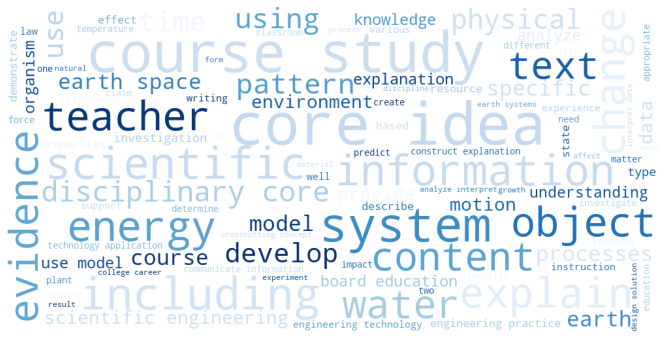

-Processedstandardsdatatxt/Alaska
('energy', 546)
('assessment', 534)
('include', 524)
('evidence', 431)
('engineering', 418)
('using', 402)
('understanding', 381)
('statement', 367)
('examples', 362)
('clarification', 361)


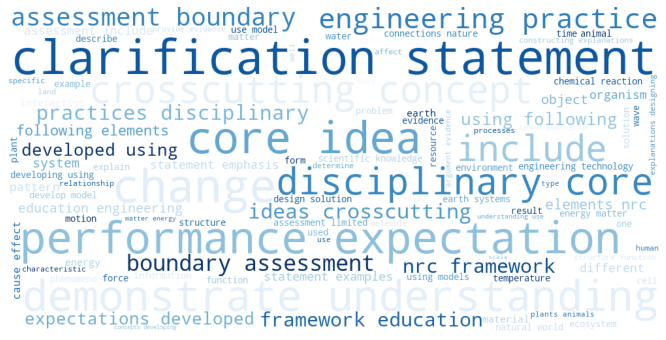

-Processedstandardsdatatxt/Arizona
('energy', 122)
('earth', 101)
('concepts', 89)
('use', 85)
('information', 85)
('crosscutting', 77)
('education', 74)
('understanding', 72)
('models', 72)
('system', 70)


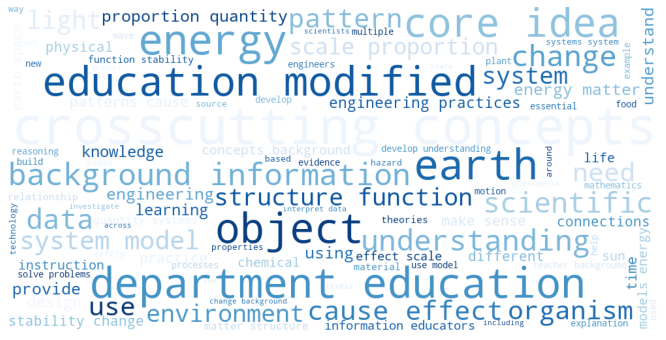

-Processedstandardsdatatxt/Colorado
('evidence', 453)
('energy', 417)
('natural', 375)
('earth', 355)
('statement', 325)
('engineering', 321)
('use', 301)
('academic', 294)
('include', 266)
('practices', 262)


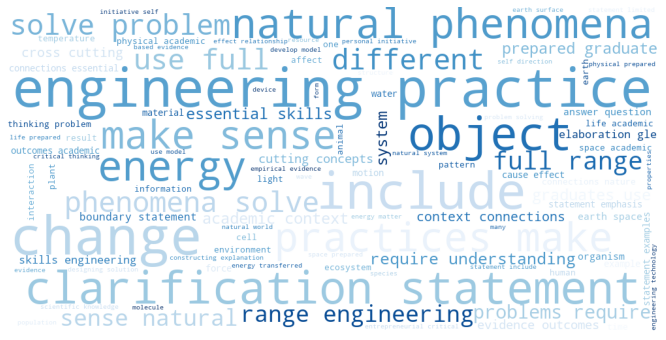

-Processedstandardsdatatxt/Flordia
('moderate', 1456)
('recognize', 1288)
('scientific', 1222)
('identify', 1191)
('describe', 866)
('explain', 782)
('energy', 551)
('knowledge', 453)
('pa', 430)
('including', 426)


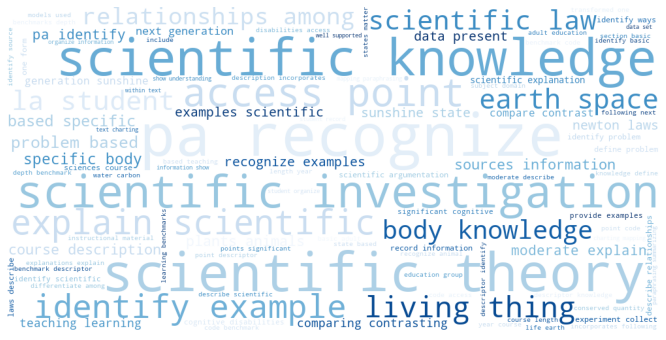

-Processedstandardsdatatxt/Georgia
('information', 85)
('excellence', 74)
('communicate', 71)
('use', 66)
('evaluate', 66)
('clarification', 62)
('statement', 62)
('obtain', 60)
('construct', 58)
('develop', 50)


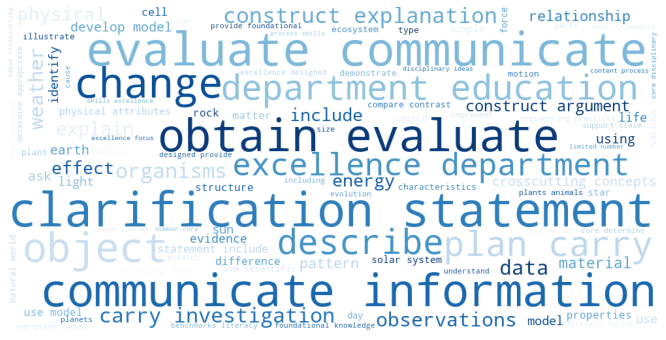

-Processedstandardsdatatxt/Idaho
('evidence', 453)
('energy', 417)
('natural', 375)
('earth', 355)
('statement', 325)
('engineering', 321)
('use', 301)
('academic', 294)
('include', 266)
('practices', 262)


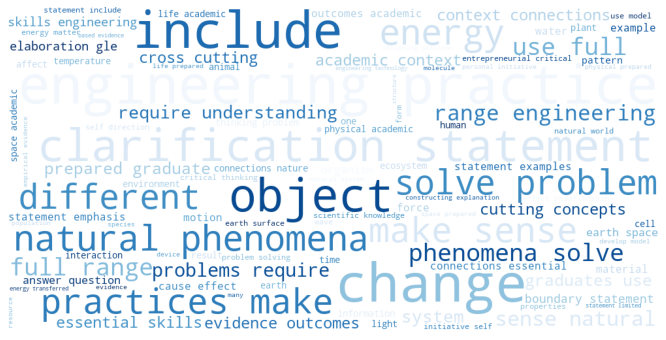

-Processedstandardsdatatxt/Indiana
('ideas', 203)
('data', 193)
('engineering', 187)
('scientists', 187)
('engineers', 187)
('describe', 181)
('models', 174)
('identify', 158)
('use', 158)
('seps', 156)


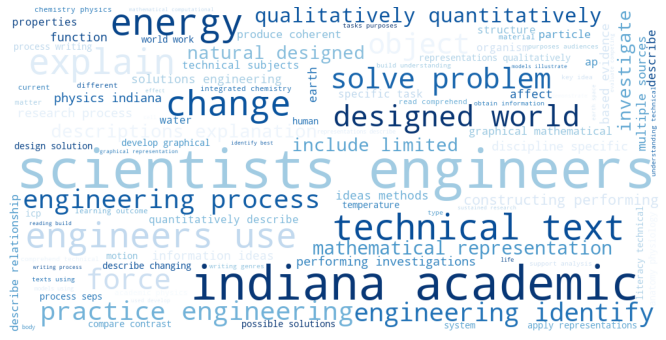

-Processedstandardsdatatxt/Louisiana
('evidence', 905)
('energy', 783)
('using', 753)
('data', 744)
('information', 626)
('problems', 558)
('solutions', 545)
('models', 542)
('use', 510)
('explanations', 447)


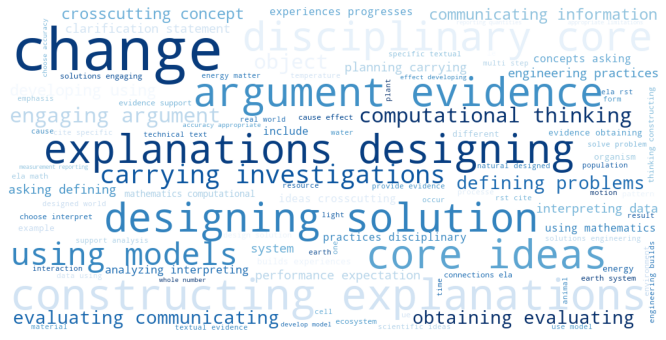

-Processedstandardsdatatxt/Maine
('performance', 425)
('use', 339)
('indicators', 295)
('learning', 277)
('state', 265)
('examples', 259)
('results', 255)
('essential', 245)
('instruction', 243)
('include', 237)


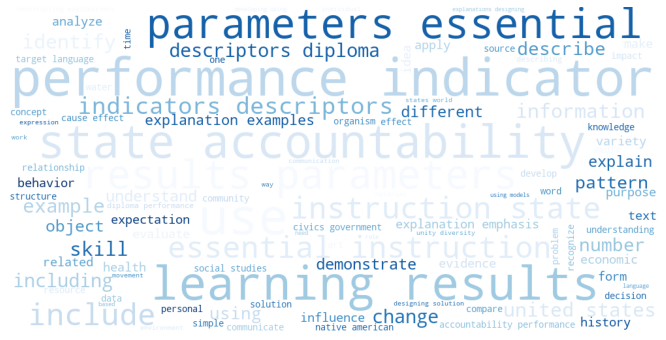

-Processedstandardsdatatxt/Mass
('engineering', 514)
('use', 315)
('technology', 311)
('practices', 304)
('include', 278)
('massachusetts', 272)
('energy', 265)
('evidence', 256)
('framework', 253)
('state', 245)


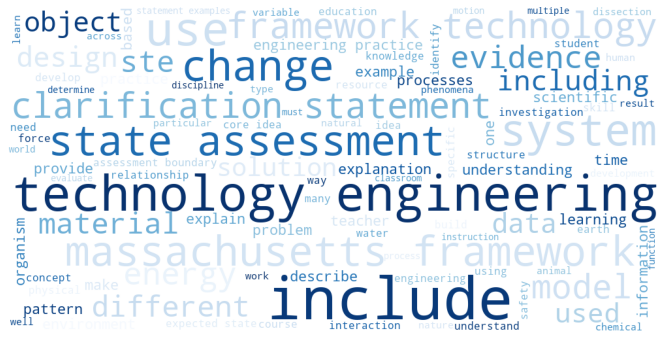

-Processedstandardsdatatxt/Michigan
('evidence', 67)
('specific', 66)
('performance', 58)
('energy', 56)
('use', 53)
('model', 51)
('engineering', 47)
('develop', 44)
('earth', 43)
('describe', 41)


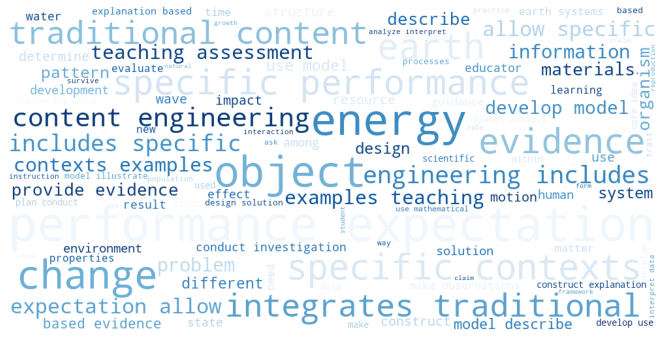

-Processedstandardsdatatxt/Minnesota
('engineering', 514)
('use', 315)
('technology', 311)
('practices', 304)
('include', 278)
('massachusetts', 272)
('energy', 265)
('evidence', 256)
('framework', 253)
('state', 245)


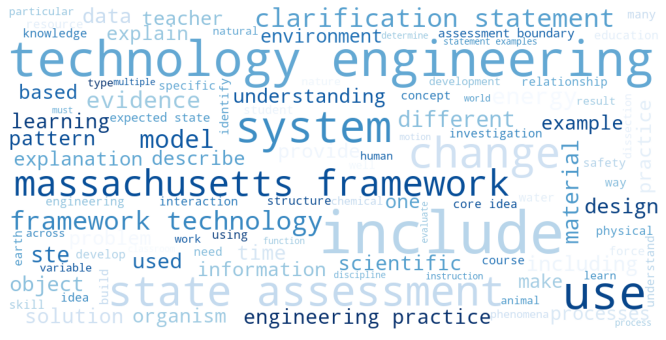

-Processedstandardsdatatxt/Mississippi
('engineering', 514)
('use', 315)
('technology', 311)
('practices', 304)
('include', 278)
('massachusetts', 272)
('energy', 265)
('evidence', 256)
('framework', 253)
('state', 245)


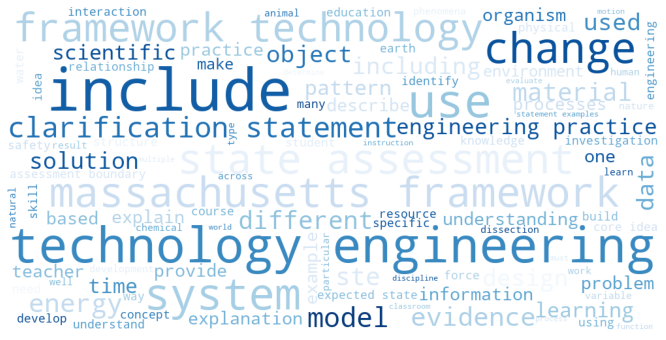

-Processedstandardsdatatxt/Missouri
('clarification', 146)
('statement', 146)
('examples', 135)
('include', 128)
('could', 101)
('energy', 94)
('evidence', 82)
('emphasis', 75)
('earth', 69)
('model', 57)


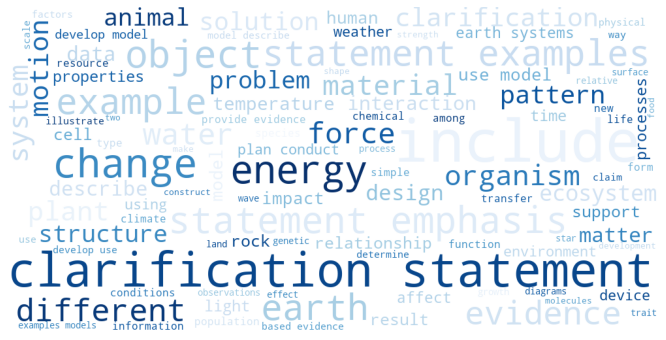

-Processedstandardsdatatxt/Montana
('engineering', 514)
('use', 315)
('technology', 311)
('practices', 304)
('include', 278)
('massachusetts', 272)
('energy', 265)
('evidence', 256)
('framework', 253)
('state', 245)


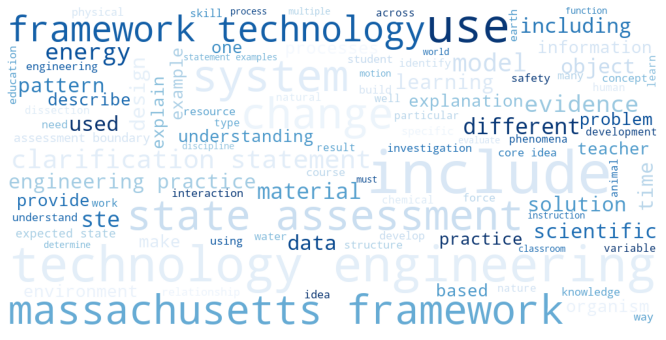

-Processedstandardsdatatxt/Nebraksa
('describe', 84)
('earth', 73)
('scientific', 70)
('recognize', 55)
('energy', 52)
('identify', 41)
('matter', 34)
('processes', 31)
('motion', 27)
('changes', 26)


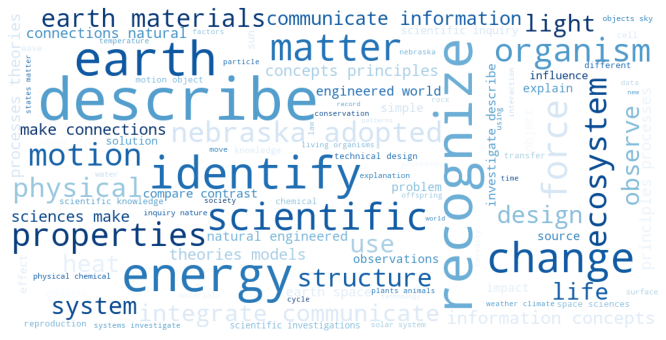

-Processedstandardsdatatxt/Northcarolina
('know', 329)
('energy', 291)
('water', 289)
('organisms', 187)
('earth', 163)
('understand', 146)
('unpacked', 138)
('content', 138)
('air', 121)
('food', 121)


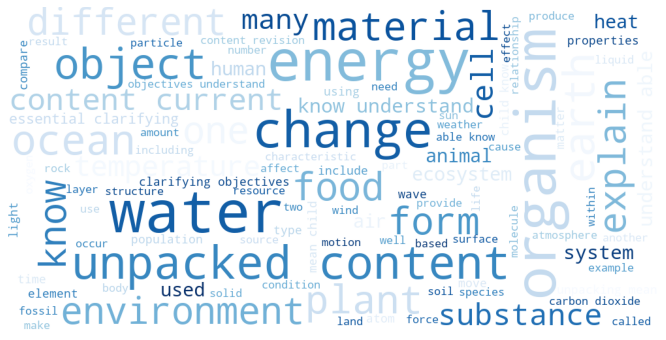

-Processedstandardsdatatxt/Northdakota
('evidence', 549)
('energy', 459)
('information', 457)
('using', 402)
('data', 390)
('nd', 348)
('assessment', 348)
('performance', 337)
('engineering', 336)
('earth', 332)


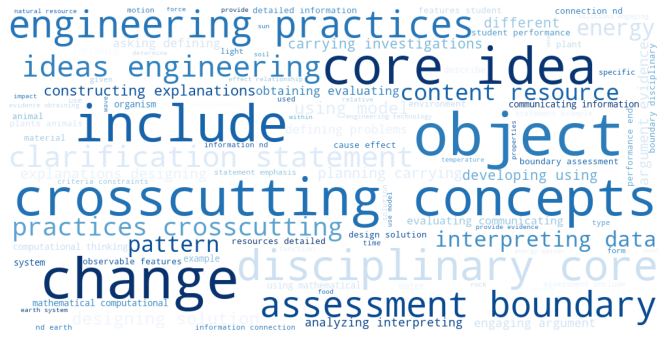

-Processedstandardsdatatxt/Ohio
('energy', 1103)
('concepts', 943)
('learning', 542)
('using', 522)
('earth', 516)
('data', 503)
('scientific', 472)
('knowledge', 453)
('water', 451)
('content', 442)


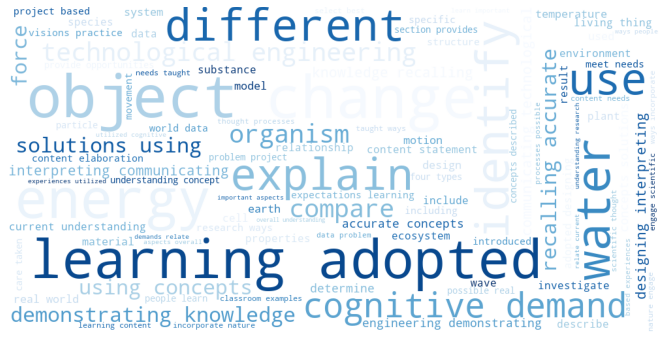

-Processedstandardsdatatxt/Oklahoma
('energy', 472)
('assessment', 412)
('include', 354)
('evidence', 322)
('ideas', 264)
('engineering', 261)
('core', 241)
('concepts', 239)
('system', 237)
('boundary', 236)


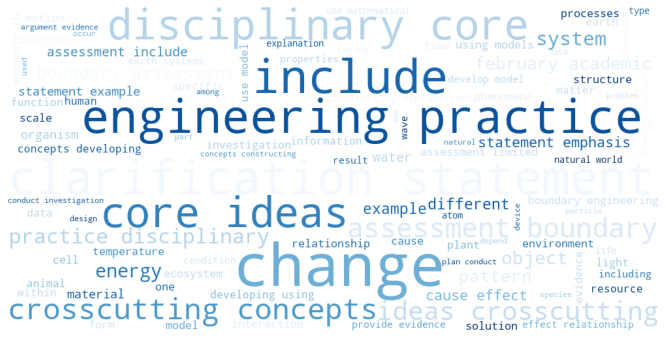

-Processedstandardsdatatxt/Pennsylvania
('describe', 124)
('identify', 117)
('apply', 111)
('explain', 106)
('technology', 104)
('systems', 83)
('knowledge', 70)
('use', 64)
('problems', 60)
('analyze', 58)


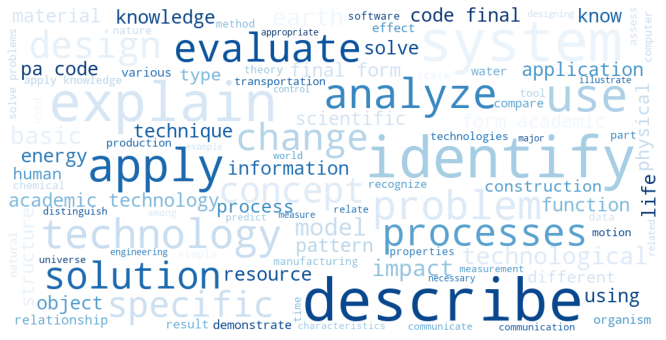

-Processedstandardsdatatxt/Southcarolina
('understanding', 312)
('use', 252)
('scientific', 246)
('demonstrate', 216)
('indicators', 202)
('performance', 188)
('energy', 181)
('earth', 180)
('data', 178)
('practices', 172)


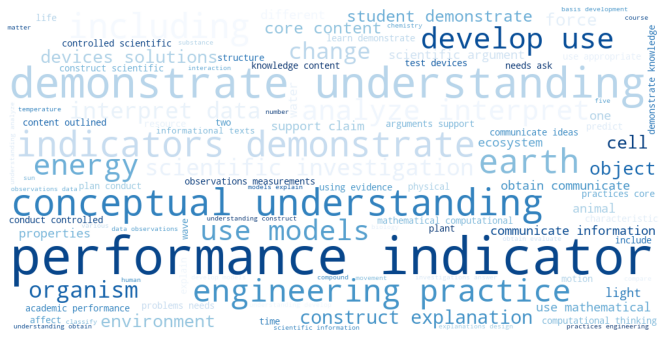

-Processedstandardsdatatxt/Southdakota
('energy', 141)
('earth', 104)
('evidence', 78)
('matter', 74)
('patterns', 69)
('cause', 65)
('effect', 64)
('use', 58)
('systems', 54)
('change', 48)


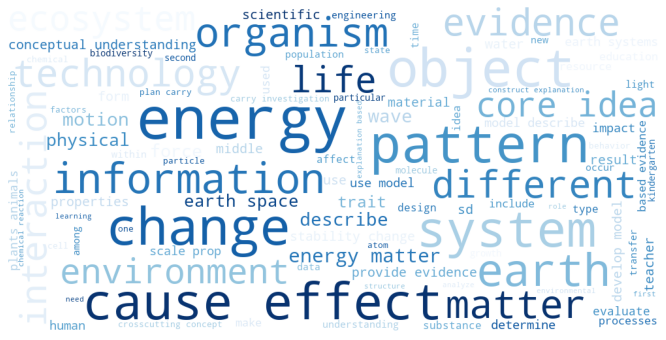

-Processedstandardsdatatxt/Tennessee
('energy', 241)
('earth', 198)
('use', 179)
('engineering', 174)
('scientific', 162)
('knowledge', 154)
('practices', 144)
('information', 129)
('explain', 127)
('data', 120)


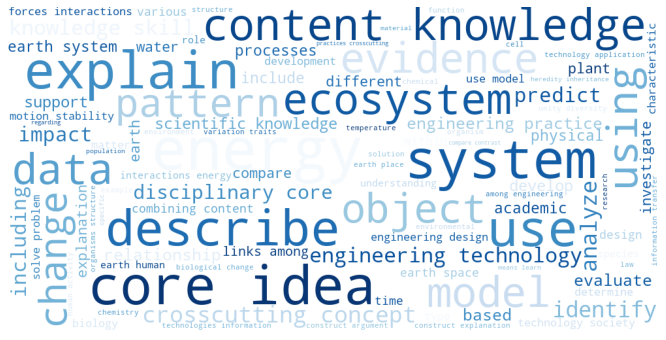

FileNotFoundError: [Errno 2] No such file or directory: 'ProcessedStandardsDataTXT/texasProcessedStandardsDataTXT/utah'

In [92]:
#create frequency list and word cloud for each state 
cleaned_words = [] 
top_words = [] 
top_5 = [] 
to_vecotrize = []
document_lenght = []

for state_name in us_states: 
    state = open_and_flatten(state_name) 
    cleaned_words.append([state_name, state])
    #look at the top 50 words on general process ngss  
    generalclean_freqdist = FreqDist(state)   
    print(f"-{state_name.title()}", *generalclean_freqdist.most_common(10), 
          sep="\n")  
    document_lenght.append(len(state))
    top_words.append([state_name, generalclean_freqdist.most_common(10)]) 
    top_5.append([state_name, generalclean_freqdist.most_common(5)]) 
    to_vecotrize.append(state)
    word_cloud(state) 

In [96]:
#lenght of all state documents
sum(document_lenght)

734125

There are definitely patterns that can be identified in the word frequencies and word clouds that align with generally what you would expect. Future work would include going through each state's corpus extensively to clean them individually. However effort has been put forth to remove any administrative or superfluous words that appear in a state's most frequently occurring word list. A complete list of those words can be seen in the projectfunctions.py file within the open_and_flatten function. 

## Word Relationships 
For each state's standards, examine the word relationships within the corpus. 

In [183]:
#aligned bigram pairs and pmi pairs for each state
for state_name in us_states:  
    state = open_and_flatten(state_name) 
    print(f"-{state_name.title()}", "\n",  
          "Bigrams:", *bigram_generator(state, 10)[:5], "\n", 
          "PMI:", *pmi_generator(state, 10)[:5], "\n\n", sep="\n")

-Alabama


Bigrams:
(('course', 'study'), 0.006496602694004053)
(('core', 'ideas'), 0.005185361783287638)
(('disciplinary', 'core'), 0.0030396948384789606)
(('earth', 'space'), 0.0023840743831207534)
(('scientific', 'engineering'), 0.002205268804386697)


PMI:
(('denoted', 'asterisk'), 10.127392535353378)
(('committee', 'task'), 9.655771507708165)
(('minutes', 'daily'), 9.28385527698913)
(('social', 'studies'), 9.236326906906545)
(('representations', 'convey'), 9.156538881012894)



-Alaska


Bigrams:
(('clarification', 'statement'), 0.008333333333333333)
(('performance', 'expectations'), 0.007079851439182916)
(('core', 'ideas'), 0.006870937790157846)
(('demonstrate', 'understanding'), 0.006685236768802228)
(('crosscutting', 'concepts'), 0.006429897864438254)


PMI:
(('pushes', 'pulls'), 11.587375707373965)
(('routinely', 'identified'), 11.307267788181234)
(('writing', 'committee'), 10.733665149624622)
(('graphical', 'displays'), 10.710232455159497)
(('called', 'organizing'), 10.655191

-Northcarolina


Bigrams:
(('unpacked', 'content'), 0.00585713679385425)
(('content', 'current'), 0.003692542761342897)
(('know', 'understand'), 0.0031832265183990493)
(('understand', 'able'), 0.0031832265183990493)
(('child', 'know'), 0.002716353295700522)


PMI:
(('achievement', 'ensuring'), 11.202185057464769)
(('effective', 'schools'), 11.202185057464769)
(('intend', 'explanations'), 11.202185057464769)
(('ncdpi', 'staff'), 11.202185057464769)
(('continually', 'updating'), 11.064681533714834)



-Northdakota


Bigrams:
(('crosscutting', 'concepts'), 0.0054263200113244935)
(('core', 'ideas'), 0.005261171141414618)
(('disciplinary', 'core'), 0.005261171141414618)
(('engineering', 'practices'), 0.0052139857500117966)
(('assessment', 'boundary'), 0.005119614967206153)


PMI:
(('colleges', 'universities'), 11.911868585468603)
(('pushes', 'pulls'), 11.670860485964813)
(('atmospheric', 'administration'), 11.233796680355972)
(('prior', 'experiences'), 11.049372109218545)
(('experiences', '

Examining these results it is clear how different the documents are. At a standard threshold (bigram 10/ pmi 50) each document some states have a large number of word associations while others have none. Future work would include exploring those states that have not returned and states and what that says about the document.  For this project I will highlight one unaligned state - Texas and one aligned state - Alaska to detail in length during my presentation, below are the gensim model word embeddings for each of their top five words. Future work would include sentiment analysis such as demonstrated below on all state's standards.

In [184]:
#texas   
texas = cleaned_words[-2][1] 

#word ebeddings 
texas_model = gensim.models.Word2Vec([texas], min_count=5, window=5, 
                               size=150)  

#examine top 10 most similar words  
texas_top_5 = ['student', 'scientific', 'including', 'expected','energy'] 

for word in texas_top_5: 
    similars = texas_model.wv.similar_by_word(word, topn=10)
    print(f"-{word}", *similars, "\n", sep="\n") 

-student
('scientific', 0.9999614357948303)
('including', 0.9999539852142334)
('earth', 0.9999462366104126)
('identify', 0.999940812587738)
('expected', 0.9999407529830933)
('processes', 0.9999383687973022)
('water', 0.9999366402626038)
('using', 0.9999363422393799)
('systems', 0.9999330043792725)
('data', 0.9999328851699829)


-scientific
('student', 0.9999614357948303)
('including', 0.9999481439590454)
('using', 0.9999447464942932)
('earth', 0.9999414086341858)
('use', 0.9999369382858276)
('investigations', 0.9999366402626038)
('expected', 0.999936580657959)
('data', 0.9999353885650635)
('compare', 0.9999333620071411)
('natural', 0.9999313354492188)


-including
('student', 0.9999539852142334)
('scientific', 0.9999481439590454)
('using', 0.9999464154243469)
('identify', 0.9999423623085022)
("earth's", 0.9999420046806335)
('expected', 0.999941885471344)
('time', 0.9999377131462097)
('earth', 0.9999377131462097)
('describe', 0.9999372959136963)
('natural', 0.9999369978904724)


-expect

In [185]:
#alaska
alaska = cleaned_words[2][1]

#word ebeddings 
alaska_model = gensim.models.Word2Vec([alaska], min_count=0, window=5, 
                               size=150) 

#examine top 10 most similar words  
alaska_top_5 = ['energy', 'assessment', 'include', 'evidence', 'engineering'] 

for word in alaska_top_5: 
    similars = alaska_model.wv.similar_by_word(word, topn=10)
    print(f"-{word}", *similars, "\n", sep="\n") 

-energy
('engineering', 0.8961971998214722)
('earth', 0.8937147259712219)
('use', 0.8912308812141418)
('objects', 0.8893035054206848)
('data', 0.8867581486701965)
('understanding', 0.885410726070404)
('models', 0.8848661184310913)
('system', 0.8805971145629883)
('scientific', 0.8773120641708374)
('organisms', 0.8761814832687378)


-assessment
('investigate', 0.3395182490348816)
('center', 0.2962666153907776)
('smaller', 0.2790239155292511)
('ideas', 0.27833160758018494)
('variables', 0.2771381437778473)
('human', 0.27255553007125854)
('environment', 0.27023839950561523)
('discourse', 0.26773083209991455)
('added', 0.26446133852005005)
('others', 0.260664165019989)


-include
('based', 0.8046170473098755)
('ideas', 0.8023850917816162)
('data', 0.791852593421936)
('using', 0.7860741019248962)
('system', 0.7835134267807007)
('organisms', 0.7822378277778625)
('education', 0.779625415802002)
('use', 0.7793275713920593)
('objects', 0.7792449593544006)
('engineering', 0.7783657908439636)


-e

In the non aligned standards (Texas) none of the most frequently occuring words are in the top 5 for NGSS high frequency. In the aligned example (Alaska) both 'evidence' and 'energy' appear in both top 5 lists. The words evidence is most positively correlated to in the NGSS and Alaska state standards do not align nor do those in energy. This might indicate that while frequency is a good metric across texts the word associations are only meaningful when looking for sentiment analysis within text.

## EDA Visuals 
Stylized, presentation graphs of high frequency words.

In [186]:
for count, value in enumerate(top_5): 
    print(f'-{(value[0].title())}')
    graph_high_frequency_words(top_5, count, value[0]) 

-Alabama


-Alaska


-Arizona


-Colorado


-Flordia


-Georgia.Txt


-Idaho


-Indiana


-Louisiana


-Maine


-Mass


-Michigan


-Minnesota


-Mississippi


-Missouri


-Montana


-Nebraksa


-Northcarolina


-Northdakota


-Ohio


-Oklahoma


-Pennsylvania


-Southcarolina


-Southdakota


-Tennessee


-Utah


-Wisconsin


-Wyoming


-Virginia


-Texas


-Virginia


# Comparing State & NGSS Standards
Examine the highest frequency words from each of the standards corpus to identify any patterns and which words are most prevalent across all standards. 

## The Age of Science Standards (EDA) 
According to most DOE state websites standards are updated on a 5 year cycle. Some states update standards at a much higher rate than others. The dates below are the most current date I could find associated with the standards I am working with (as of January 2021). I am interested in seeing the distribution of states standard dates as well as how that breaks down between NGSS adopted/ NGSS aligned/ and Independent states.

In [187]:
#unpickle state dictionary
state_df = pd.read_pickle("./state_df.pkl") 
#transpose values
state_df = state_df.T 

In [188]:
#reset index
state_df.reset_index(inplace=True)

In [189]:
#set column name
state_df = state_df.rename(columns={'index': 'state'})   

two_letter = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 
              'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 
              'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
              'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 
              'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
state_df['two_letter'] = two_letter 
state_df.head()

state update_year standards two_letter
0     alabama        2015   aligned         AL
1     alaskas        2017   aligned         AK
2     arizona        2018   aligned         AZ
3    arkansas        2016   adopted         AR
4  california        2013   adopted         CA

In [190]:
#visualize the age of science standards 
grouped_df = state_df.groupby('update_year').count() 
grouped_df

state  standards  two_letter
update_year                              
2002             1          1           1
2003             1          1           1
2004             1          1           1
2008             1          1           1
2013             6          6           6
2014             3          3           3
2015             8          8           8
2016            11         11          11
2017             5          5           5
2018             4          4           4
2019             5          5           5
2020             3          3           3
20202            1          1           1

In [191]:
#graph the stat counts by year and alignment
fig = go.Figure() 

years= [2002, 2003, 2004, 2008, 2013, 2014, 2015, 2016, 
        2017, 2018, 2019, 2020] 

fig = go.Figure()
fig.add_trace(go.Bar(x=years,
                y=[0, 0, 0, 0, 6, 2, 5, 4, 0, 0, 0, 1],
                name='NGSS Adopted States',
                marker_color='rgb(75, 117, 156)'
                ))
fig.add_trace(go.Bar(x=years,
                y=[0, 0, 0, 0, 0, 1, 2, 7, 4, 3, 3, 3],
                name='NGSS Aligned States',
                marker_color='rgb(26, 118, 255)'
                )) 
fig.add_trace(go.Bar(x=years,
                y=[1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 2, 0],
                name='Independent Standards States',
                marker_color='rgb(135, 206, 235)'
                ))

fig.update_layout(
    title='Date of Science Standard Development by Standard Group',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Total Number of States',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
) 

fig.add_annotation(x=2002, y=1,
            text="Pennsylvania",
            showarrow=True,
            arrowhead=1) 

fig.add_annotation(x=2004, y=1,
            text="North Carolina",
            showarrow=True,
            arrowhead=1, 
            ax=-30,
            ay=-70) 

fig.add_annotation(x=2008, y=1,
            text="Flordia",
            showarrow=True,
            arrowhead=1)
fig.show(renderer="svg")

NGSS standards were developed in 2013 so this increase in adopted states at that time makes sense. Those states have used NGSS since the beginning, there is a large spike 3 years after the initial release of states that are aligned with NGSS, this might be due to high efficacy of standards or simply the cycle of updating standards coincided with a few years into NGSS so it was less 'risky' to adopt. The outlier states with particularly old standards are all independent states. 

## Geographical Distribution of Standard Alignment
Map the geographical distribution of the adoption of NGSS standards across the US. 

In [192]:
with urlopen("https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json") as response: 
    counties = json.load(response)
    
fig = px.choropleth(state_df, locations='two_letter', 
                    locationmode="USA-states", color='standards', scope='usa',
                    color_discrete_sequence=('rgb(26, 118, 255)', 
                                             'rgb(75, 117, 156)', 
                                             'rgb(135, 206, 235)'))  
         
fig.update_layout(title_text = 'NGSS Standards Distribution')
fig.show(renderer="svg")

## Comparing the Highest Frequency Words
An examination of pattern in the highest frequency words per corpus.

In [193]:
#create a df of the top 10 words for each state 
freq_words = pd.DataFrame(top_words, columns = ['Standards', 'Top10']) 

#explode the nested list & transpose df  
words = freq_words['Top10'].apply(pd.Series)
words = words.rename(columns = lambda x : 'word_' + str(x))  

#join and transpose
word_df = pd.concat([freq_words[:], words[:]], axis=1).T

#reset column index
word_df = word_df.rename(columns=word_df.iloc[0]).drop(word_df.index[0]).T 
word_df.head()

Top10  \
alabama   [(scientific, 163), (course, 142), (earth, 142...   
alaska    [(energy, 546), (assessment, 534), (include, 5...   
arizona   [(energy, 122), (earth, 101), (concepts, 89), ...   
colorado  [(evidence, 453), (energy, 417), (natural, 375...   
flordia   [(moderate, 1456), (recognize, 1288), (scienti...   

                     word_0             word_1              word_2  \
alabama   (scientific, 163)      (course, 142)        (earth, 142)   
alaska        (energy, 546)  (assessment, 534)      (include, 524)   
arizona       (energy, 122)       (earth, 101)      (concepts, 89)   
colorado    (evidence, 453)      (energy, 417)      (natural, 375)   
flordia    (moderate, 1456)  (recognize, 1288)  (scientific, 1222)   

                    word_3              word_4              word_5  \
alabama         (use, 141)         (core, 129)  (engineering, 127)   
alaska     (evidence, 431)  (engineering, 418)        (using, 402)   
arizona          (use, 85)   (information, 85)  (crosscutting, 77)   
colorado      (earth, 355)    (statement, 325)  (engineering, 321)   
flordia   (identify, 1191)     (describe, 866)      (explain, 782)   

                        word_6               word_7            word_8  \
alabama     (information, 123)         (study, 121)  (education, 117)   
alaska    (understanding, 381)     (statement, 367)   (examples, 362)   
arizona        (education, 74)  (understanding, 72)      (models, 72)   
colorado            (use, 301)      (academic, 294)    (include, 266)   
flordia          (energy, 551)     (knowledge, 453)         (pa, 430)   

                        word_9  
alabama           (ideas, 116)  
alaska    (clarification, 361)  
arizona           (system, 70)  
colorado      (practices, 262)  
flordia       (including, 426)

In [194]:
#highest frequency ngss words
ngss_top10

[('evidence', 467),
 ('core', 438),
 ('ideas', 415),
 ('energy', 389),
 ('include', 305),
 ('using', 304),
 ('information', 302),
 ('engineering', 299),
 ('use', 296),
 ('data', 292)]

In [195]:
#unpickle state dictionary
state_df = pd.read_pickle("./state_df.pkl") 
#transpose values
state_df = state_df.T  
#reset index
state_df.reset_index(inplace=True)

In [196]:
#merge the state df with highest frequency word
state_words = pd.merge(state_df, word_df[['word_0']].reset_index(), 
                       how='outer')

Any Nan values in this merged dataframe are indications that the state is an NGSS 'adopted' state. So their top word will all be the same - 'evidence'.

In [197]:
#fill na
state_words = state_words.fillna(str(ngss_top10[0]))

In [198]:
#cast state words as strings
state_words = state_words.astype(str)

In [199]:
#format the new dataframe columns

#cast state words as strings
state_words = state_words.astype(str)

#strip extra characters from new rows
state_words['frequency'] = state_words["word_0"].apply(lambda x: x.strip(")").strip("(").split(",")[1])

state_words['top_word'] = state_words["word_0"].apply(lambda x: x.strip(")").strip("(").strip("''").split(",")[0]) 

state_words['top_word'] = state_words['top_word'].str[:-1]  

In [200]:
#drop extra rows and columns 
state_words = state_words.drop(columns='word_0')
state_words = state_words.drop([51, 52, 53, 54, 55, 56, 57, 58])  

#fix funky value
state_words.loc[[17],['update_year']] = 2020 

#sanity check
state_words.head()

index update_year standards frequency    top_word
0     alabama        2015   aligned       163  scientific
1     alaskas        2017   aligned       467    evidence
2     arizona        2018   aligned       122      energy
3    arkansas        2016   adopted       467    evidence
4  california        2013   adopted       467    evidence

In [201]:
#group index by alignment and word
top_word_grouped = state_words.groupby(['standards', 'top_word', 'frequency', 'index']).sum()   
top_word_grouped.reset_index(inplace=True) 

#fix funky value
top_word_grouped.loc[[42],['update_year']] = 2018 

In [202]:
#get the count for word use across df
top_word_grouped.groupby('top_word').count()

standards  frequency  index  update_year
top_word                                               
clarification          1          1      1            1
concepts               1          1      1            1
describe               1          1      1            1
energy                 5          5      5            5
engineering            3          3      3            3
evidence              32         32     32           32
extended               1          1      1            1
ideas                  1          1      1            1
moderate               1          1      1            1
performance            1          1      1            1
scientific             1          1      1            1
student                1          1      1            1
use                    1          1      1            1

In [203]:
top_word_grouped['count'] = [32 if x=='evidence' else 
                             (5 if x=='energy' else 
                              (3 if x=='engineering' else 1)) 
                              for x in top_word_grouped['top_word']]

In [204]:
top_word_grouped['frequency'] = top_word_grouped['frequency'].astype(int)

In [205]:
top_word_grouped.loc[top_word_grouped['standards'] == 'aligned'] 

#save data frame
#top_word_grouped.to_csv(index=False) 
#compression_opts = dict(method='zip',
                        #archive_name='out.csv')  
#df.to_csv('out.zip', index=False,
          #compression=compression_opts) 

standards       top_word  frequency           index update_year  count
20   aligned  clarification        146        missouri        2016      1
21   aligned         energy        122         arizona        2018      5
22   aligned         energy        210            utah        2019      5
23   aligned         energy        241       tennessee        2016      5
24   aligned         energy        472        oklahoma        2020      5
25   aligned    engineering        514       minnesota        2019      3
26   aligned    engineering        514     mississippi        2018      3
27   aligned    engineering        514         montana        2016      3
28   aligned       evidence        453        colorado        2020     32
29   aligned       evidence        453           idaho        2018     32
30   aligned       evidence        467         alaskas        2017     32
31   aligned       evidence        467         georgia        2016     32
32   aligned       evidence        467   massachusetts        2016     32
33   aligned       evidence        467        nebraska        2017     32
34   aligned       evidence        467    north dakota        2019     32
35   aligned       evidence        467  south carolina        2014     32
36   aligned       evidence        467    south dakota        2016     32
37   aligned       evidence        905       louisiana        2020     32
38   aligned       extended        396         wyoming        2017      1
39   aligned          ideas        203         indiana        2016      1
40   aligned     scientific        163         alabama        2015      1
41   aligned            use        206       wisconsin        2017      1

In [206]:
fig = px.sunburst(top_word_grouped, path=['standards', 'top_word'], values='count', color='standards') 
fig.update_layout(title='Most Commonly Occuring Word Accross Standards')
fig.show(renderer="svg")

## Clustering All Standards 
Clustering state standards to identify patterns of intra textual relationships. State's that are aligned with the NGSS standards should cluster closer to states that are independent. Additionally clustering may lead to better insight into which states are more closely grouped than others. This code is borrowed heavily from Brandon Rose's excellent project on the same subject which can be seen [here](https://github.com/brandomr/document_cluster/blob/master/cluster_analysis_web.ipynb)

In [207]:
#create a nested list
s = ['ngss'] 
s.append(ngss) 

#create a ngss dataframe
ngss_corpi = pd.DataFrame(s, columns=["corpus"]) 
ngss_corpi['state'] = "ngss" 
ngss_corpi.drop([0], axis=0)

corpus state
1  [topic, arrangements, next, generation, beginn...  ngss

In [208]:
#create a state dataframe 
state_corpi = pd.DataFrame(cleaned_words, columns=["state", "corpus"]) 

#join states & ngss
standards_corpi = pd.concat([state_corpi, ngss_corpi], axis=0)  
standards_corpi = standards_corpi.reset_index().drop([31], axis=0)
standards_corpi = standards_corpi.reset_index().drop(columns=['index'])  

standards_corpi.head()

level_0     state                                             corpus
0        0   alabama  [information, regarding, course, study, materi...
1        1    alaska  [dept, education, early, development, board, e...
2        2   arizona  [department, education, academic, introduction...
3        3  colorado  [review, revision, committee, chairpersons, jo...
4        4   flordia  [specifications, florida, state, adoption, ins...

In [209]:
#clearn corpus column
standards_corpi['corpus'] = standards_corpi['corpus'].astype(str)  
standards_corpi['corpus'] = standards_corpi['corpus'].apply(lambda x: x.strip("[").strip("]"))

In [210]:
#set features & labels to list
corpi_list = standards_corpi['corpus'].values.tolist() 
state_list = standards_corpi['state'].values.tolist()

In [211]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(corpi_list)

/Users/kristen/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.



In [212]:
#values needed later for kmeans 
terms = tfidf_vectorizer.get_feature_names() 
dist = 1 - cosine_similarity(tfidf_matrix)

In [213]:
#preform k means clustering

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [214]:
cluster_list = pd.DataFrame({'cluster': clusters, 'state': state_list})
cluster_list['cluster'].value_counts() 

2    16
1    14
0     2
Name: cluster, dtype: int64

In [215]:
cluster_list

cluster          state
0         2        alabama
1         1         alaska
2         2        arizona
3         1       colorado
4         2        flordia
5         1    georgia.txt
6         1          idaho
7         2        indiana
8         1      louisiana
9         2          maine
10        1           mass
11        2       michigan
12        1      minnesota
13        1    mississippi
14        1       missouri
15        1        montana
16        2       nebraksa
17        2  northcarolina
18        1    northdakota
19        2           ohio
20        1       oklahoma
21        2   pennsylvania
22        2  southcarolina
23        2    southdakota
24        2      tennessee
25        2           utah
26        2      wisconsin
27        1        wyoming
28        0       virginia
29        2          texas
30        0       virginia
31        1           ngss

In [216]:
MDS() 

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist) 

xs, ys = pos[:, 0], pos[:, 1]

In [217]:
df = pd.DataFrame({'cluster': clusters, 'state': state_list, 'x':xs, 'y':ys})

In [218]:
cluster_names = {0: 'Not Aligned', 
                 1: 'Somewhat Aligned', 
                 2: 'Very Aligned'}

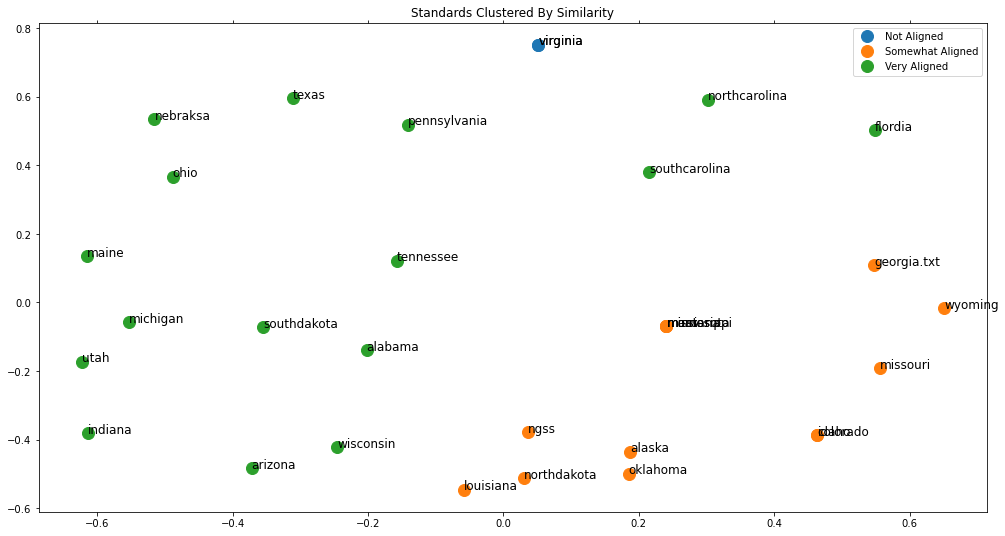

In [219]:
#group by cluster
groups = df.groupby('cluster')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) 
ax.margins(0.05) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name]) 
    
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',     
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         
        which='both',      
        left='off',      
        top='off',         
        labelleft='off') 
     
ax.legend(numpoints=1)  

for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['state'], size=12)  

plt.title("Standards Clustered By Similarity")    
plt.show() #show

This looks great! The independently developed state standards have all been classified correctly! There is an interesting split of states that are in the somewhat aligned group. I will save this metric and track it as I continue to go. Next I am going to visualize the groupings hierarchically which should again, highlight in more nuance how closely aligned two corpus are.

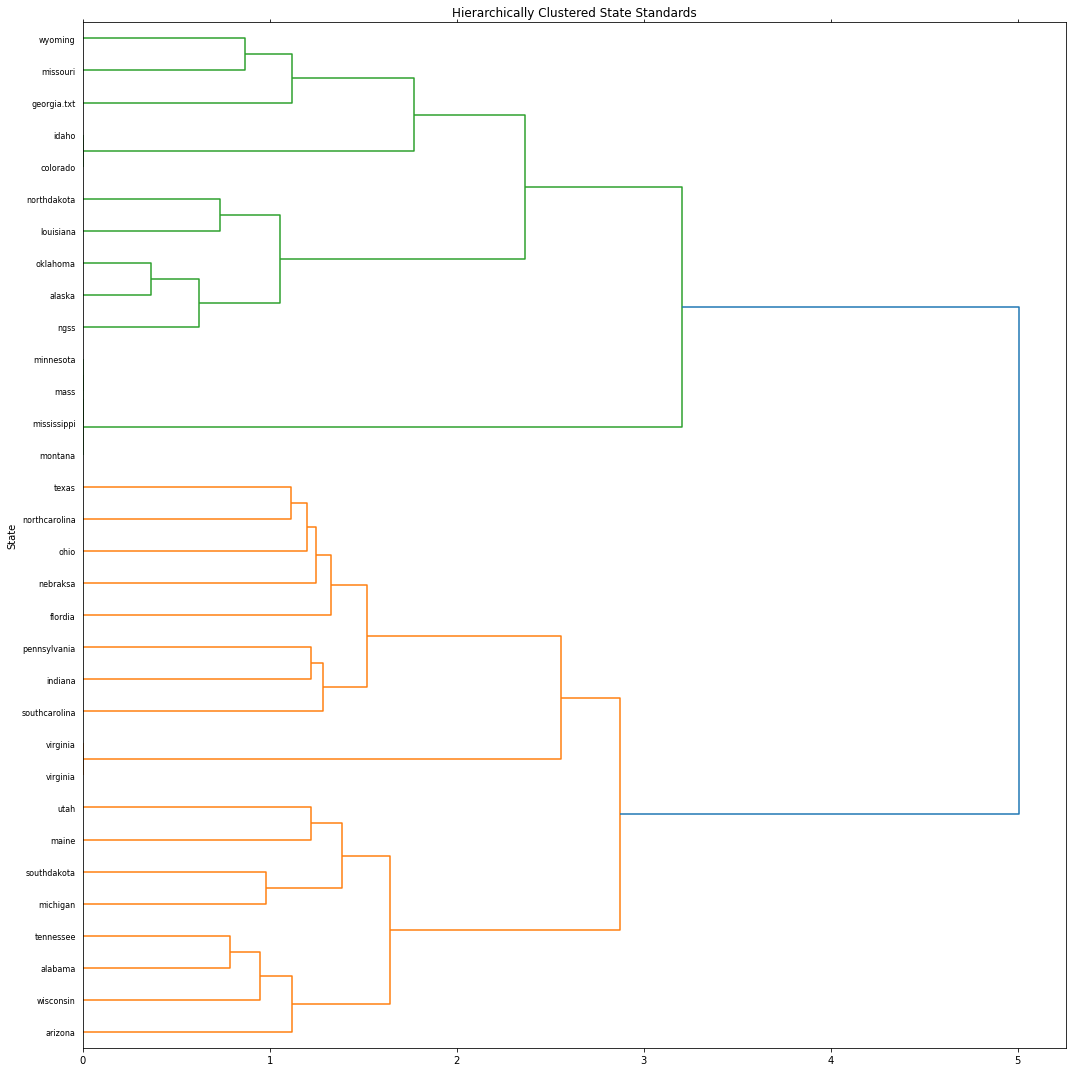

In [220]:
#visualize hierarchical connections
linkage_matrix = ward(dist) 

fig, ax = plt.subplots(figsize=(15, 15)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=state_list);

plt.tick_params(\
    axis= 'x',          
    which='both',      
    bottom='off',      
    top='off',         
    labelbottom='off') 

plt.title('Hierarchically Clustered State Standards') 
plt.ylabel('State')

plt.tight_layout()

This really clearly shows two large and equally sized groups that diverge at 3 degrees of cosine difference. In one group is NGSS standards and the other prominent independent standards such as Texas. This is a powerful tool to quickly visualize the degree of similarity to pieced of writing have to one another. I will add each states cluster to a scores df to use in my final attempt to quantify alignment. 

In [221]:
scores = df.drop(['x', 'y'], axis =1)

In [222]:
scores = scores.drop([30,31], axis=0)

## Scattertext 
Using the Scattertext library (found [here](https://github.com/JasonKessler/scattertext#using-scattertext-as-a-text-analysis-library-finding-characteristic-terms-and-their-associations)) to classify word importance in text This powerful library has a lot of built in functions that quickly (and beautiful) process NLP tasks such as word sentiment and association. In conjunction with a report or audit of a groups alignment this tools (touched only briefly here would add impressive visuals on deliverables.

In [223]:
#unpickle state dictionary
state_df_no_adopted = pd.read_pickle("./state_df_no_adopted.pkl") 

In [224]:
#edit list to remove ngss and duplicate 
standards_corpi2 = standards_corpi.drop([30,31], axis=0)

In [225]:
#status will be considered a label for this dataset
standards_corpi2['status'] = (state_df_no_adopted.T['standards'].values) 
standards_corpi2.head()

level_0     state                                             corpus  \
0        0   alabama  'information', 'regarding', 'course', 'study',...   
1        1    alaska  'dept', 'education', 'early', 'development', '...   
2        2   arizona  'department', 'education', 'academic', 'introd...   
3        3  colorado  'review', 'revision', 'committee', 'chairperso...   
4        4   flordia  'specifications', 'florida', 'state', 'adoptio...   

        status  
0      aligned  
1      aligned  
2      aligned  
3      aligned  
4  independent

In [226]:
scatter_text = standards_corpi2[['corpus', 'status']]

In [227]:
import scattertext as st
import spacy
from pprint import pprint

In [228]:
# Turn it into a Scattertext Corpus 
nlp = spacy.load('en')
corpus = st.CorpusFromPandas(scatter_text, 
                             category_col='status', 
                              text_col='corpus',
                             nlp=nlp).build()

In [229]:
#unique corpus words 
print("Corpus Unique Words:")
word = list(corpus.get_scaled_f_scores_vs_background().index[:10]) 
for w in word: 
    print("-", w)

Corpus Unique Words:
- crosscutting
- clarification
- organisms
- explanations
- ngss
- phenomena
- constructing
- hydrosphere
- dissection
- photosynthesis


In [230]:
#words most associated with aligned states 
print("Aligned State Score:")
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Aligned Score'] = corpus.get_scaled_f_scores('aligned')
al = list(term_freq_df.sort_values(by='Aligned Score', ascending=False).index[:20])
for a in al: 
    print("-", a)

Aligned State Score:
- massachusetts framework
- boundary assessment
- framework technology
- ideas crosscutting
- massachusetts
- nrc
- ste
- assessment boundary
- progresses
- phenomena solve
- ela
- assessment include
- expected state
- experiences progresses
- practices make
- range engineering
- full range
- sense natural
- require understanding
- use full


The list is insightful and also brings a point of future work to process data more/ iterate over the cleaning project to remove words like "Massachusetts" from the list.

In [231]:
#words most associated with aligned states 
print("Independent State Score:")
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Independent Score'] = corpus.get_scaled_f_scores('independent')
ind = list(term_freq_df.sort_values(by='Independent Score', ascending=False)
           .index[:20])
for i in ind: 
    print("-", i)

Independent State Score:
- communicating technological
- demonstrating knowledge
- interpreting communicating
- ses
- engineering demonstrating
- learning adopted
- cognitive demands
- chapter learning
- results parameters
- recalling accurate
- parameters essential
- essential instruction
- state accountability
- knowledge recalling
- accountability page
- technological engineering
- concepts solutions
- designing interpreting
- accurate concepts
- extended benchmarks


This package has extensive html visualizations that are beyond the scope of this current project but would be a powerful addition in future work. The text analysis in this package is a great way to quickly understand what text is part of a corpus and what isn't. Often an organization like NGSS is deeply concerned with the manner in which they represent themselves. Implementing this tool would allow for easy self audit of language use as well as analysis of other groups text. 

# Quantifying Alignment Between State & NGSS Standards
Using a wide variety of NLP techniques and similarity scores compare the standards from each state to that of the NGSS standards to begin building a measure for alignment. For the purposes of this project alignment will be defined by how similar two corpus are semantically. The theory behind this is that organizations that are aligned should describe a similar topic in similar ways i.e. the language a state that is aligned to the NGSS standards chooses to use should be similar to the language used to describe a specific standard or grade band.

## Cosine Distance (Gensim)
Use gensim similarity to compare whole text alignment between NGSS (set as index) and each of the state's standards. 

In [232]:
# Set the NGSS Index  
ngss_docs = []
with open ('ngs') as f:
    tokens = sent_tokenize(f.read())
    for line in tokens:
        ngss_docs.append(line)

#preprocess ngss file using the gensim model
processed_ngss = preprocess_documents(ngss_docs)

#create a ngss dictionary
ngss_dictionary = gensim.corpora.Dictionary(processed_ngss) 

#create the corpus 
ngss_corpus = [ngss_dictionary.doc2bow(processed_ngss) for processed_ngss in 
               processed_ngss] 

In [233]:
#set the index to ngss standards 
tf_idf = gensim.models.TfidfModel(ngss_corpus)
sims = gensim.similarities.Similarity('/Users/kristen/Flatiron/Capstone', 
                                      tf_idf[ngss_corpus], 
                                      num_features=len(ngss_dictionary))

Using a custom built function run a comparison of each state's standards, returning a rounded percentage score to indicate similarity of document (alignment). This is a sum of cosine similarity scores to the index that has been summed and divided by the length of that state's corpus. Because it is using the NGSS corpus I did not move it to the py functions document but the functionization is still useful to apply to all states efficiently. 

In [234]:
def compare_docs(textfile):   
    """Compares the NGSS indexed corpus to another corpus for similarity  
    Args: 
        textfile: a txt file 
    
    Returns: 
        A similarity score between txt file and NGSS index
        
    """
  
    current_doc = []
    with open (textfile) as f:
        tokens = sent_tokenize(f.read())
        for line in tokens:
            current_doc.append(line) 
    
    processed_doc = preprocess_documents(current_doc)  
    dictionary_current = gensim.corpora.Dictionary(processed_doc)  
    corpus_current = [dictionary_current.doc2bow(processed_doc) 
                      for processed_doc in processed_doc]  
    tf_idf = gensim.models.TfidfModel(ngss_corpus)
            
    current_doc_tf_idf = tf_idf[corpus_current]
    sum_of_sim =(np.sum(sims[current_doc_tf_idf], dtype=np.float32)) 
    percentage_of_similarity = round(float(sum_of_sim / len(current_doc)))
    name = state.title() 
    print("{} Alignment: %{}".format(name, percentage_of_similarity))

In [235]:
for state in us_states:   
    compare_docs(state)

Alabama Alignment: %16
Alaska Alignment: %23
Arizona Alignment: %27
Colorado Alignment: %14
Flordia Alignment: %17
Georgia.Txt Alignment: %31
Idaho Alignment: %14
Indiana Alignment: %39
Louisiana Alignment: %23
Maine Alignment: %19
Mass Alignment: %18
Michigan Alignment: %27
Minnesota Alignment: %18
Mississippi Alignment: %18
Missouri Alignment: %29
Montana Alignment: %18
Nebraksa Alignment: %34
Northcarolina Alignment: %23
Northdakota Alignment: %15
Ohio Alignment: %16
Oklahoma Alignment: %24
Pennsylvania Alignment: %22
Southcarolina Alignment: %21
Southdakota Alignment: %20
Tennessee Alignment: %24
Utah Alignment: %10
Wisconsin Alignment: %16
Wyoming Alignment: %13
Virginia Alignment: %26
Texas Alignment: %32
Virginia Alignment: %26


Looking at this score nothing is above 40% which is not surprising for whole text comparison however the aligned states do tend to score higher than the independently developed states. There are exceptions to this such as Virgina (unaligned/ scored 27%) but aligned states such as Georgia (31%) do show promise. While this metric alone could not be used to quantify alignment it does highlight similarity trends. Future work could apply this method to a corpus of just standard and see if that improved results. 

In [236]:
#add scores to my scores dataframe
g_scores = [16, 23, 27, 14, 17, 31, 14, 39, 23, 19, 18, 27, 18, 18, 29, 18, 34,
          23, 15, 16, 24, 22, 21, 20, 24, 10, 16, 13, 26, 32]
scores['gensim_score'] = g_scores 

scores.head()

cluster     state  gensim_score
0        2   alabama            16
1        1    alaska            23
2        2   arizona            27
3        1  colorado            14
4        2   flordia            17

## Word Mover's Distance  
Word Mover's Distance calculates the 'steps' needed to get from one document to another. Thus a low score would indicate a highly similar (aligned) document from a Word2Vec model that has been pre-trained on Google News data.

In [237]:
#build model
filename = '/Users/kristen/Downloads/GoogleNews-vectors-negative300.bin.gz'
w2v = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=True) 

w2v.init_sims(replace=True)   

First I will calculate the wmd score for two standards that are fairly similar, this should produce a relatively low score, and demonstrate effectiveness of this metric.

In [238]:
#test text
sentence_a = """Plan and conduct an investigation to describe and classify 
             different kinds of materials by their observable properties""" 

sentence_b = """Conduct an investigation to describe and classify various 
             substances according to physical properties""" 

sentence_a = sentence_a.lower().split()
sentence_b = sentence_b.lower().split()

stop_words = stopwords.words('english') 

sentence_a = [w for w in sentence_a if w not in stop_words]
sentence_b = [w for w in sentence_b if w not in stop_words] 

w2v.wmdistance(sentence_a, sentence_b)

0.5952981265197317

In [239]:
#random sentence comparison 
random_a = """For a quick examination of how word vectors work, check out 
           my previous article about them.""" 

random_b = """A sedated female platypus received a physical exam at the 
           Taronga Wildlife Hospital in Mosman New South Wales Australia."""


random_a = random_a.lower().split()
random_b = random_b.lower().split() 

stop_words = stopwords.words('english')
random_a = [w for w in random_a if w not in stop_words]
random_b = [w for w in random_b if w not in stop_words] 

w2v.wmdistance(random_a, random_b)

1.2805050754945468

Low value score on the test text vs the random test demonstrates effectiveness. Future work could apply this standard by standard and then compile all scores for a more structured approach but for the purposes of this project I will calculate each states whole cleaned corpus score when compared to the NGSS corpus of cleaned words.

In [240]:
#ngss comparison string 
ngss_string = ' '.join(ngss_processed)

In [241]:
state_scores = []

for state in us_states: 
    state_processed = open_and_flatten(state) 
    state_string = ' '.join(state_processed) 
    score = w2v.wmdistance(ngss_string, state_string)  
    state_scores.append([score])
    print(f"{state}: {score}")

alabama: 0.020213985425070555
alaska: 0.017739611906786457
arizona: 0.02403654519281452
colorado: 0.02089371072841296
flordia: 0.03320255778942672
georgia.txt: 0.03279117569369351
idaho: 0.02089371072841296
indiana: 0.0190756612204309
louisiana: 0.021463600495176156
maine: 0.02251409102977526
mass: 0.017769751813743816
michigan: 0.03085347975658237
minnesota: 0.017769751813743816
mississippi: 0.017769751813743816
missouri: 0.03002641273942177
montana: 0.017769751813743816
nebraksa: 0.04592341721057129
northcarolina: 0.047036011484178054
northdakota: 0.02478937086318499
ohio: 0.024649538405047477
oklahoma: 0.023032754490465376
pennsylvania: 0.04289562792810987
southcarolina: 0.022442536409205245
southdakota: 0.04021814709283876
tennessee: 0.02547561933830473
utah: 0.024207855332378642
wisconsin: 0.016386716438909123
wyoming: 0.04296039957026097
virginia: 0.02626909575761956
texas: 0.023528015431275338
virginia: 0.02626909575761956


This metric returned really low scores across the board (indicating that the documents are highly similar to begin with) but there is more consistency with independent/ aligned standards. In this metric Pennsylvania (independent), for example, has a relatively high score (0.04) as compared to Wisconsin's (aligned) low score (0.02). This metric alone should not be to evaluate alignment alone but the emerging pattern could be used in conjunction with other scores.

In [242]:
#add mover's distance scores to scores dataframe 
scores['movers_distance'] = state_scores[:-1]

## Levenshtein Distance (Fuzzy Wuzzy)
Using the Fuzzy Wuzzy Text Matching library to compare similarity between text documents. This library allows for fuzzy matching, which should return generally higher results than other similarity metrics. 

In [243]:
#test metric on single standards string   
sentence_a = """Plan and conduct an investigation to describe and classify 
             different kinds of materials by their observable properties""" 

sentence_b = """Conduct an investigation to describe and classify various 
             substances according to physical properties""" 

print("Fuzz Ratio Score: ", 
      fuzz.ratio(sentence_a, sentence_b))
print("Fuzz Partial Ratio Score: ",
      fuzz.partial_ratio(sentence_a, sentence_b)) 
print("Fuzz Token Sort Ratio Score: ", 
      fuzz.token_sort_ratio(sentence_a, sentence_b))

Fuzz Ratio Score:  70
Fuzz Partial Ratio Score:  70
Fuzz Token Sort Ratio Score:  65


For the single standard test the Fuzz Partial Ratio & Ratio scored preformed the best. I will apply those two to the general data to see which is a better metric for whole text strings. 

In [244]:
#set features & labels to list
corpi_list = standards_corpi['corpus'].values.tolist() 
state_list = standards_corpi['state'].values.tolist()

In [245]:
us_states = ['alabama', 'alaska', 'arizona','colorado', 'flordia',  
             'georgia.txt', 'idaho', 'indiana', 'louisiana', 'maine', 'mass', 
             'michigan','minnesota', 'mississippi', 'missouri', 'montana',
             'nebraksa', 'northcarolina', 'northdakota', 'ohio','oklahoma', 
             'pennsylvania', 'southcarolina', 'southdakota', 'tennessee', 
             'utah', 'wisconsin', 'wyoming', 'virginia', 'texas'] 

The ratio model was successful, the highest scoring state in the Fuzzy Wuzzy algorithm is Alaska (an aligned state) and the lowest scoring is Michigan (an independent state). This metric does not have any unusual scores and I would say then is a fairly good quantifier of how closely aligned two documents are. It was computationally very expensive - scores are stored below & code block as been set to plain code (reset to run).

In [246]:
fuzzy_score =[39, 62, 30, 48, 43, 23, 48, 42, 43, 46, 45, 19, 45, 45, 26, 45, 
              13, 41, 47, 40, 48, 27, 40, 24, 40, 35, 39, 44, 26, 40] 

#add mover's distance scores to scores dataframe 
scores['fuzzy'] = fuzzy_score 

## Monge Elkan Distance
Using the py_stringmatching library to compare text document similarity this a combined sequence based and set based distance measurement. A distance score that is closer to 1 will represent a most similar string comparison. 

In [247]:
#test on a single string 
me = MongeElkan()
me.get_raw_score(['Plan', 'and', 'conduct', 'an', 'investigation', 'to', 
                  'describe', 'and', 'classify', 'different', 'kinds', 'of', 
                  'materials', 'by', 'their', 'observable properties'], 
                 ['Conduct', 'an', 'investigation', 'to', 'describe', 'and',
                  'classify', 'various', 'substances', 'according', 'to', 
                  'physical', 'properties'])

0.7991203740239143

In [248]:
#test on random string   
me = MongeElkan()
me.get_raw_score(['For', 'a', 'quick', 'examination', 'of', 'how', 'word',
                  'vectors', 'work', 'check', 'out', 'my', 'previous',
                  'article', 'about', 'them'], 
                 ['A', 'sedated', 'female', 'platypus', 'received', 'a', 
                  'physical', 'exam', 'at', 'the', 'Taronga', 'Wildlife',
                  'Hospital', 'in', 'Mosman', 'New', 'South', 'Wales',
                  'Australia'])

0.675507765263319

The scores here do show a very close correlation between the standards but a surprisingly high score between the random strings. Since I didn't process them at all it might be correlating stop words in this example and returning unusually high score on the random test. I will apply each state's standards (processed) to this distance metric. Aligned states should return values closer to one than those that are independent. 

In [249]:
ngss_words = [idx for idx, val in ngss_top10]
ngss_words

['evidence',
 'core',
 'ideas',
 'energy',
 'include',
 'using',
 'information',
 'engineering',
 'use',
 'data']

After much trial and error it was too computationally epensive for the algorithm to measure string distance on the entire corpus, instead I have run the comparison on a specific number of high frequency words to at least gauge a metric for how similar the texts most commonly used words are. This metric could be run on larger strings with higher computational/ cloud computing.

In [252]:
me_scores = []
for i in range(0, 31): 
    my_ids = [idx for idx, val in top_words[i][1]] 
    me = MongeElkan()
    me_score = me.get_raw_score(ngss_words, my_ids) 
    me_scores.append(me_score) 

me_scores = me_scores [:-1]

In [253]:
scores['me'] = me_scores

## Levenshtein Distance (Non Fuzzy Wuzzy)
Using the py_stringmatching library to compare text document similarity this distance reflects the total number of single-character edits required to transform one word into another. For this metric a lower score would indicate a closer text file. 

In [254]:
#test single standard 
sentence_a = """Plan and conduct an investigation to describe and classify 
             different kinds of materials by their observable properties""" 

sentence_b = """Conduct an investigation to describe and classify various 
             substances according to physical properties""" 
lev = Levenshtein()
lev.get_sim_score(sentence_a, sentence_b)

0.5757575757575757

In [255]:
#random sentence comparison 
random_a = """For a quick examination of how word vectors work, check out 
           my previous article about them.""" 

random_b = """A sedated female platypus received a physical exam at the 
           Taronga Wildlife Hospital in Mosman New South Wales Australia.""" 

lev = Levenshtein()
lev.get_sim_score(random_a, random_b)

0.23484848484848486

This computation was also impossible to do with the whole corpus so it has been processed similarly to the ME score on the top words from each corpus, these two scores will then be comparable in analysis.

In [259]:
#cast list as single string
ngss_words_string = " ".join(ngss_words)

In [262]:
#caluclate the lev score for each state's list
lev_scores = []
for i in range(0, 31): 
    my_ids = [idx for idx, val in top_words[i][1]]  
    state_string = ' '.join(my_ids) 
    lev = Levenshtein()
    lev_score = lev.get_raw_score(ngss_words_string, state_string) 
    lev_scores.append(lev_score) 

lev_scores = lev_scores [:-1]

In [264]:
#append the scores to the scores list
scores['lev'] = lev_scores

## Jaccard Distance 
This is a distance metric is described in the documentation as a "python library for comparing distance between two or more sequences by many algorithms". The lower a score returns the closer in 'distance' the strings are.

In [265]:
jac = Jaccard()
jac.get_raw_score(['Plan', 'and', 'conduct', 'an', 'investigation', 'to', 
                  'describe', 'and', 'classify', 'different', 'kinds', 'of', 
                  'materials', 'by', 'their', 'observable properties'], 
                 ['Conduct', 'an', 'investigation', 'to', 'describe', 'and',
                  'classify', 'various', 'substances', 'according', 'to', 
                  'physical', 'properties'])

0.2857142857142857

Functionize the Jaccard score to run across the whole corpus.

In [283]:
jac_scores = [] 

for state in us_states:  
    flat_list = [item for sublist in state for item in sublist] 
    jac = jaccard_similarity(flat_list, ngss_string)  
    jac_scores.append(jac)
    print(state, jac)

alabama 1.181324441898034e-05
alaska 1.1813279307269301e-05
arizona 1.7719971293646503e-05
colorado 1.7719918960903952e-05
flordia 2.067336089781453e-05
georgia.txt 2.362648883796068e-05
idaho 1.4766686355581808e-05
indiana 1.181324441898034e-05
louisiana 2.067323878772128e-05
maine 1.4766686355581808e-05
mass 8.859985646823251e-06
michigan 2.0673299842587588e-05
minnesota 2.3626628391528672e-05
mississippi 1.1813104867885189e-05
missouri 1.7719918960903952e-05
montana 1.4766599134086628e-05
nebraksa 2.0673299842587588e-05
northcarolina 2.6579721444519262e-05
northdakota 2.362648883796068e-05
ohio 8.859985646823251e-06
oklahoma 1.7719918960903952e-05
pennsylvania 2.6579799942705766e-05
southcarolina 3.248651809499058e-05
southdakota 2.362648883796068e-05
tennessee 1.1813174643020628e-05
utah 1.1813349084465446e-05
wisconsin 1.7719866628470508e-05
wyoming 2.067336089781453e-05
virginia 1.7719918960903952e-05
texas 1.4766686355581808e-05


In [287]:
#append to scores dictionary 
scores['jaccard'] = jac_scores

## BagDistance 
Computes the normalized distance between two strings. The closer the similarity score is to 1 the closer the strings are.

In [288]:
bd = BagDistance()
bd.get_sim_score('Plan and conduct an investigation to describe and classify \
                 different kinds of materials by their observable properties', 
                 'Conduct an investigation to describe and classify various \
                 substances according to physical properties')

0.7627118644067796

In [296]:
bag_scores = [] 

for state in us_states:  
    state_processed = open_and_flatten(state) 
    state_string = ' '.join(state_processed) 
    bag = bd.get_sim_score(state_string, ngss_string)  
    bag_scores.append(bag)
    print(state, bag)

alabama 0.4185705847607797
alaska 0.9144822181385797
arizona 0.23101594802126402
colorado 0.8026845835794447
flordia 0.6065458948880684
georgia.txt 0.15409923213230947
idaho 0.8026845835794447
indiana 0.5488127584170113
louisiana 0.5618238534545696
maine 0.9286887182516244
mass 0.9759775546367395
michigan 0.11578854105138803
minnesota 0.9759775546367395
mississippi 0.9759775546367395
missouri 0.17360011813349085
montana 0.9759775546367395
nebraksa 0.07433549911399884
northcarolina 0.536550502067336
northdakota 0.9392403301460047
ohio 0.4848724381665922
oklahoma 0.7386089781453042
pennsylvania 0.19069108092144127
southcarolina 0.45936207914943883
southdakota 0.16057590076786765
tennessee 0.45196692262256355
utah 0.319111045481394
wisconsin 0.4052303603071471
wyoming 0.5727347903130537
virginia 0.1849291199054932
texas 0.44976077968103956


In [300]:
scores['bag_distance'] = bag_scores

## String Score Analysis 
The above metrics for string scores are only seven of the may available in the py.stringmatching package. Future work would include adding the other metrics to this calculation to further strengthen and conclusions draw from the analysis. 

Score Cheat Sheet:  

Whole Corpus Metrics Used
1. Clusters - 0: 'Not Aligned', 2: 'Somewhat Aligned', 1: 'Very Aligned'   
2. Gensim: Rounded Percentage the larger the more similar the strings
3. Mover's Distance - Decimal calculation lower the more similar the strings  
4. Fuzzy String Matching - Decimal calculation the higher the more similar the strings 
5. Bag Distance - Decimal calculation the closer the score is to one the more similar the strings.

Partial Corpus Metrics Used 
1. Monge Elken - Decimal calculation the closer to one the more similar the strings  
2. Levenshtein - Decimal calculation the higher the more similar the strings 

In [301]:
scores

cluster          state  gensim_score         movers_distance  fuzzy  \
0         2        alabama            16  [0.020213985425070555]     39   
1         1         alaska            23  [0.017739611906786457]     62   
2         2        arizona            27   [0.02403654519281452]     30   
3         1       colorado            14   [0.02089371072841296]     48   
4         2        flordia            17   [0.03320255778942672]     43   
5         1    georgia.txt            31   [0.03279117569369351]     23   
6         1          idaho            14   [0.02089371072841296]     48   
7         2        indiana            39    [0.0190756612204309]     42   
8         1      louisiana            23  [0.021463600495176156]     43   
9         2          maine            19   [0.02251409102977526]     46   
10        1           mass            18  [0.017769751813743816]     45   
11        2       michigan            27   [0.03085347975658237]     19   
12        1      minnesota            18  [0.017769751813743816]     45   
13        1    mississippi            18  [0.017769751813743816]     45   
14        1       missouri            29   [0.03002641273942177]     26   
15        1        montana            18  [0.017769751813743816]     45   
16        2       nebraksa            34   [0.04592341721057129]     13   
17        2  northcarolina            23  [0.047036011484178054]     41   
18        1    northdakota            15   [0.02478937086318499]     47   
19        2           ohio            16  [0.024649538405047477]     40   
20        1       oklahoma            24  [0.023032754490465376]     48   
21        2   pennsylvania            22   [0.04289562792810987]     27   
22        2  southcarolina            21  [0.022442536409205245]     40   
23        2    southdakota            20   [0.04021814709283876]     24   
24        2      tennessee            24   [0.02547561933830473]     40   
25        2           utah            10  [0.024207855332378642]     35   
26        2      wisconsin            16  [0.016386716438909123]     39   
27        1        wyoming            13   [0.04296039957026097]     44   
28        0       virginia            26   [0.02626909575761956]     26   
29        2          texas            32  [0.023528015431275338]     40   

          me  lev   jaccard  bag_distance  
0   0.850904   48  0.000012      0.418571  
1   0.832174   68  0.000012      0.914482  
2   0.786867   58  0.000018      0.231016  
3   0.821055   54  0.000018      0.802685  
4   0.723263   62  0.000021      0.606546  
5   0.706210   72  0.000024      0.154099  
6   0.821055   54  0.000015      0.802685  
7   0.803773   57  0.000012      0.548813  
8   0.866907   55  0.000021      0.561824  
9   0.738179   66  0.000015      0.928689  
10  0.804985   64  0.000009      0.975978  
11  0.786038   48  0.000021      0.115789  
12  0.804985   64  0.000024      0.975978  
13  0.804985   64  0.000012      0.975978  
14  0.761839   62  0.000018      0.173600  
15  0.804985   64  0.000015      0.975978  
16  0.697922   63  0.000021      0.074335  
17  0.695436   57  0.000027      0.536551  
18  0.854877   47  0.000024      0.939240  
19  0.771230   58  0.000009      0.484872  
20  0.846912   58  0.000018      0.738609  
21  0.692767   63  0.000027      0.190691  
22  0.770804   66  0.000032      0.459362  
23  0.756190   61  0.000024      0.160576  
24  0.821372   55  0.000012      0.451967  
25  0.761465   51  0.000012      0.319111  
26  0.822427   58  0.000018      0.405230  
27  0.732054   58  0.000021      0.572735  
28  0.746183   62  0.000018      0.184929  
29  0.779522   62  0.000015      0.449761

While the individual scores vary, Alaska is a great example of a state that scored fairly consistently across metrics and is an NGSS aligned state that seems to have very similar writing in its corpus as the NGSS. Thus you could conclude was a very aligned state (more so than others that claim to be aligned).

In [303]:
#somewhat aligned
cluster2 = scores.loc[scores['cluster'] == 2] 
cluster2

cluster          state  gensim_score         movers_distance  fuzzy  \
0         2        alabama            16  [0.020213985425070555]     39   
2         2        arizona            27   [0.02403654519281452]     30   
4         2        flordia            17   [0.03320255778942672]     43   
7         2        indiana            39    [0.0190756612204309]     42   
9         2          maine            19   [0.02251409102977526]     46   
11        2       michigan            27   [0.03085347975658237]     19   
16        2       nebraksa            34   [0.04592341721057129]     13   
17        2  northcarolina            23  [0.047036011484178054]     41   
19        2           ohio            16  [0.024649538405047477]     40   
21        2   pennsylvania            22   [0.04289562792810987]     27   
22        2  southcarolina            21  [0.022442536409205245]     40   
23        2    southdakota            20   [0.04021814709283876]     24   
24        2      tennessee            24   [0.02547561933830473]     40   
25        2           utah            10  [0.024207855332378642]     35   
26        2      wisconsin            16  [0.016386716438909123]     39   
29        2          texas            32  [0.023528015431275338]     40   

          me  lev   jaccard  bag_distance  
0   0.850904   48  0.000012      0.418571  
2   0.786867   58  0.000018      0.231016  
4   0.723263   62  0.000021      0.606546  
7   0.803773   57  0.000012      0.548813  
9   0.738179   66  0.000015      0.928689  
11  0.786038   48  0.000021      0.115789  
16  0.697922   63  0.000021      0.074335  
17  0.695436   57  0.000027      0.536551  
19  0.771230   58  0.000009      0.484872  
21  0.692767   63  0.000027      0.190691  
22  0.770804   66  0.000032      0.459362  
23  0.756190   61  0.000024      0.160576  
24  0.821372   55  0.000012      0.451967  
25  0.761465   51  0.000012      0.319111  
26  0.822427   58  0.000018      0.405230  
29  0.779522   62  0.000015      0.449761

In [328]:
#very aligned 
cluster1 = scores.loc[scores['cluster'] == 1] 
cluster1

cluster        state  gensim_score         movers_distance  fuzzy  \
1         1       alaska            23  [0.017739611906786457]     62   
3         1     colorado            14   [0.02089371072841296]     48   
5         1  georgia.txt            31   [0.03279117569369351]     23   
6         1        idaho            14   [0.02089371072841296]     48   
8         1    louisiana            23  [0.021463600495176156]     43   
10        1         mass            18  [0.017769751813743816]     45   
12        1    minnesota            18  [0.017769751813743816]     45   
13        1  mississippi            18  [0.017769751813743816]     45   
14        1     missouri            29   [0.03002641273942177]     26   
15        1      montana            18  [0.017769751813743816]     45   
18        1  northdakota            15   [0.02478937086318499]     47   
20        1     oklahoma            24  [0.023032754490465376]     48   
27        1      wyoming            13   [0.04296039957026097]     44   

          me  lev   jaccard  bag_distance  
1   0.832174   68  0.000012      0.914482  
3   0.821055   54  0.000018      0.802685  
5   0.706210   72  0.000024      0.154099  
6   0.821055   54  0.000015      0.802685  
8   0.866907   55  0.000021      0.561824  
10  0.804985   64  0.000009      0.975978  
12  0.804985   64  0.000024      0.975978  
13  0.804985   64  0.000012      0.975978  
14  0.761839   62  0.000018      0.173600  
15  0.804985   64  0.000015      0.975978  
18  0.854877   47  0.000024      0.939240  
20  0.846912   58  0.000018      0.738609  
27  0.732054   58  0.000021      0.572735

Scale all scores using z_score to create comparison metric. 

In [354]:
scores['gensim_score'] = scores['gensim_score'].astype(int)

In [360]:
scores['movers_distance'] = scores['movers_distance'].astype(str)
scores['movers_distance'] = scores['movers_distance'].apply(lambda x: 
                                                            x.strip("[")
                                                            .strip("]"))
scores['movers_distance'] = scores['movers_distance'].astype(float)

In [361]:
cols = list(scores.columns)  
cols.remove('cluster')
cols.remove('state')
cols

['gensim_score',
 'movers_distance',
 'fuzzy',
 'me',
 'lev',
 'jaccard',
 'bag_distance',
 'cluster_zscore',
 'gensim_score_zscore']

In [362]:
for col in cols:
    col_zscore = col + '_zscore'
    scores[col_zscore] = (scores[col] - scores[col].mean())/scores[col].std(ddof=0)
scores

cluster          state  gensim_score  movers_distance  fuzzy        me  \
0         2        alabama            16         0.020214     39  0.850904   
1         1         alaska            23         0.017740     62  0.832174   
2         2        arizona            27         0.024037     30  0.786867   
3         1       colorado            14         0.020894     48  0.821055   
4         2        flordia            17         0.033203     43  0.723263   
5         1    georgia.txt            31         0.032791     23  0.706210   
6         1          idaho            14         0.020894     48  0.821055   
7         2        indiana            39         0.019076     42  0.803773   
8         1      louisiana            23         0.021464     43  0.866907   
9         2          maine            19         0.022514     46  0.738179   
10        1           mass            18         0.017770     45  0.804985   
11        2       michigan            27         0.030853     19  0.786038   
12        1      minnesota            18         0.017770     45  0.804985   
13        1    mississippi            18         0.017770     45  0.804985   
14        1       missouri            29         0.030026     26  0.761839   
15        1        montana            18         0.017770     45  0.804985   
16        2       nebraksa            34         0.045923     13  0.697922   
17        2  northcarolina            23         0.047036     41  0.695436   
18        1    northdakota            15         0.024789     47  0.854877   
19        2           ohio            16         0.024650     40  0.771230   
20        1       oklahoma            24         0.023033     48  0.846912   
21        2   pennsylvania            22         0.042896     27  0.692767   
22        2  southcarolina            21         0.022443     40  0.770804   
23        2    southdakota            20         0.040218     24  0.756190   
24        2      tennessee            24         0.025476     40  0.821372   
25        2           utah            10         0.024208     35  0.761465   
26        2      wisconsin            16         0.016387     39  0.822427   
27        1        wyoming            13         0.042960     44  0.732054   
28        0       virginia            26         0.026269     26  0.746183   
29        2          texas            32         0.023528     40  0.779522   

    lev   jaccard  bag_distance  cluster_zscore  gensim_score_zscore  \
0    48  0.000012      0.418571        0.923381            -0.830640   
1    68  0.000012      0.914482       -0.718185             0.213877   
2    58  0.000018      0.231016        0.923381             0.810745   
3    54  0.000018      0.802685       -0.718185            -1.129074   
4    62  0.000021      0.606546        0.923381            -0.681423   
5    72  0.000024      0.154099       -0.718185             1.407612   
6    54  0.000015      0.802685       -0.718185            -1.129074   
7    57  0.000012      0.548813        0.923381             2.601346   
8    55  0.000021      0.561824       -0.718185             0.213877   
9    66  0.000015      0.928689        0.923381            -0.382990   
10   64  0.000009      0.975978       -0.718185            -0.532207   
11   48  0.000021      0.115789        0.923381             0.810745   
12   64  0.000024      0.975978       -0.718185            -0.532207   
13   64  0.000012      0.975978       -0.718185            -0.532207   
14   62  0.000018      0.173600       -0.718185             1.109178   
15   64  0.000015      0.975978       -0.718185            -0.532207   
16   63  0.000021      0.074335        0.923381             1.855262   
17   57  0.000027      0.536551        0.923381             0.213877   
18   47  0.000024      0.939240       -0.718185            -0.979857   
19   58  0.000009      0.484872        0.923381            -0.830640   
20   58  0.000018      0.738609       -0.718185             0.363094   
2

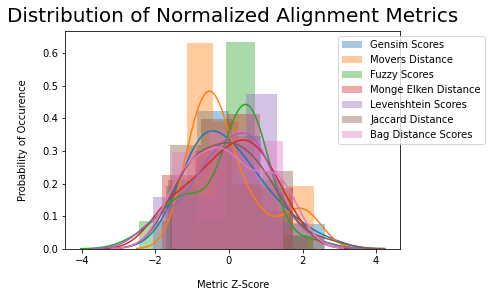

In [376]:
sns.distplot(scores['gensim_score_zscore'], label='Gensim Scores')
sns.distplot(scores['movers_distance_zscore'], label='Movers Distance') 
sns.distplot(scores['fuzzy_zscore'], label='Fuzzy Scores')
sns.distplot(scores['me_zscore'], label='Monge Elken Distance') 
sns.distplot(scores['lev_zscore'], label='Levenshtein Scores')
sns.distplot(scores['jaccard_zscore'], label='Jaccard Distance') 
sns.distplot(scores['bag_distance_zscore'], label='Bag Distance Scores')
#plt.axvline(x=height_leslie_inches, linestyle='--', linewidth=2.5, label="Leslie's height", c='indigo')
#plt.axvline(x=height_jamie_inches, linestyle='--', linewidth=2.5, label="Jamie's height", c='slategrey')
plt.xlabel("Metric Z-Score", labelpad=14)
plt.ylabel("Probability of Occurence", labelpad=14)
plt.title("Distribution of Normalized Alignment Metrics", y=1.015, fontsize=20)
plt.legend(bbox_to_anchor=(0.8, 1));

In [378]:
zcols = ['gensim_score_zscore', 'movers_distance_zscore',
         'fuzzy_zscore', 'me_zscore', 'lev_zscore', 'jaccard_zscore',
         'bag_distance_zscore']

In [392]:
scores['alignment'] = (scores[zcols].sum(axis=1)/7).abs() *100  
pd.options.display.float_format = "{:,.2f}".format

In [393]:
scores[['state','alignment']] 

#set state index, .style to add indentatino(caption), .style background gradient 

state  alignment
0         alabama      49.39
1          alaska      59.54
2         arizona      20.92
3        colorado       1.14
4         flordia       6.87
5     georgia.txt      13.35
6           idaho       8.60
7         indiana      16.05
8       louisiana      23.77
9           maine      12.58
10           mass       3.47
11       michigan      47.44
12      minnesota      40.80
13    mississippi      10.94
14       missouri      13.00
15        montana      18.40
16       nebraksa       8.28
17  northcarolina      30.55
18    northdakota      20.39
19           ohio      44.41
20       oklahoma      37.68
21   pennsylvania       0.44
22  southcarolina      40.29
23    southdakota       8.34
24      tennessee      12.73
25           utah      84.92
26      wisconsin      25.53
27        wyoming       6.71
28       virginia      29.44
29          texas      13.17

It worked! The higher the alignment score (a sum of the standardized scores from seven different string distance metrics) the more closely aligned that states standards are to the NGSS standards. Future would strength this idea further by adding more metrics and examine additional mathematical methods for comparing dis similarly scaled items. 